<a href="https://colab.research.google.com/github/rianashaba20/Machine-Learning-Jets-Classification/blob/main/MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.openml.org/search?type=data&status=active&id=42468&sort=runs  


Paper: https://iopscience.iop.org/article/10.1088/1748-0221/13/07/P07027 (page 9, Figure 5 are the ROC & Confusion Matrix plots we are comparing with)

**Running the cells with the optimizers takes hours, and Colab tends to disconnect sometimes, so the numbers of the cells are not in order, but the results are correct and consistent with the content. Only that different parts of the workflow have been ran at different times, while saving the outputs.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [ ]:
# always run this command
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.1 MB/s eta 0:00:00


In [ ]:
# run this too
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.8/253.8 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.2
    Uninstalling xgboost-3.0.2:
      Successfully uninstalled xgboost-3.0.2


# 1) **Data Processing**

In [ ]:
# load the jet tagging dataset and get the features and the target
data = fetch_openml('hls4ml_lhc_jets_hlf', as_frame=True)
x, y = data['data'], data['target']         # x holds the features; y holds the target

# since this is a large dataset, will cast features to float32 for better memory usage
x = x.astype("float32")

In [ ]:
# print the feature names and the total number of features
print(f'The feature names are: {data["feature_names"]} \n The number of features is {len(data["feature_names"])}.')

The feature names are: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity'] 
 The number of features is 16.


In [ ]:
print(x, x.shape)

           zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.040022    0.005620    0.020352    0.000804   
829997 -3.338864    0.467011    0.075235    0.017644    0.097954    0.022681   
829998 -1.535967    0.335411    0.002537    0.000021    0.002692    0.000017   
829999 -2.987995    0.455648    0.005218    0.000073    0.006994    0.000099   

        d2_b1_mmdt  d2_b2_mmdt  d2_a1_b

In [ ]:
print(y, y.shape)

0         g
1         w
2         t
3         z
4         w
         ..
829995    z
829996    w
829997    t
829998    q
829999    g
Name: class, Length: 830000, dtype: category
Categories (5, object): ['g', 'q', 't', 'w', 'z'] (830000,)


### Check if the data is balanced or not

g: 167125 samples
q: 161066 samples
t: 167851 samples
w: 167083 samples
z: 166875 samples


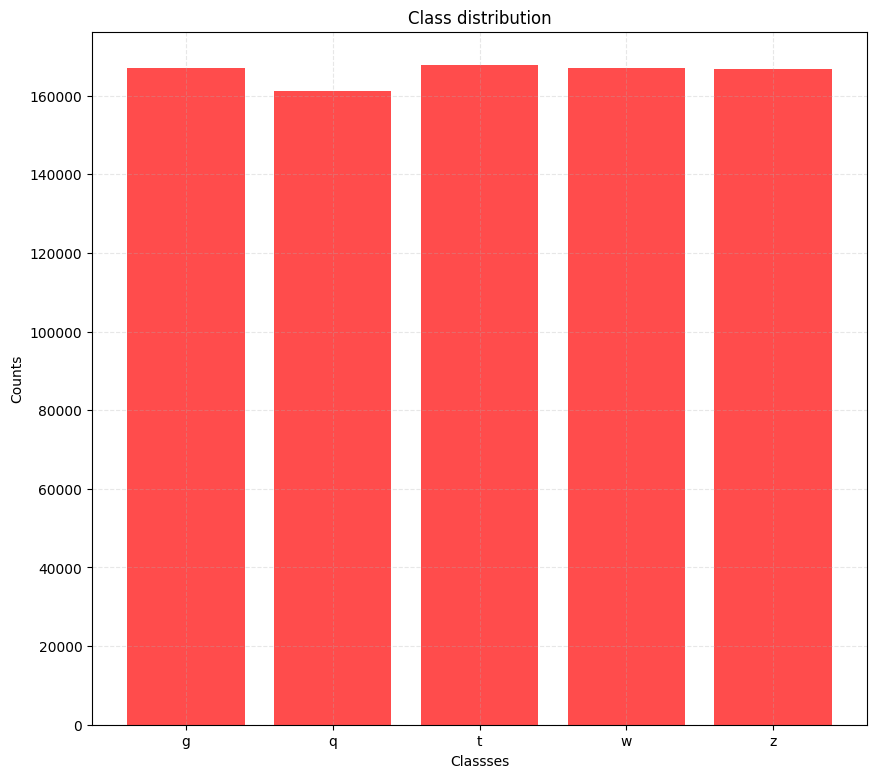

In [ ]:
# count how many samples are for each class
counts = y.value_counts().sort_index()

for name, count in counts.items():
  print(f"{name}: {count} samples")

plt.figure(figsize=(10,9))
plt.bar(counts.index, counts.values, color="red", alpha=0.7)
plt.xlabel("Classses")
plt.ylabel("Counts")
plt.title("Class distribution")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [ ]:
total = sum(counts)
for name, count in counts.items():
  print(f"{name}: {(count/total)*100:.2f}%")

g: 20.14%
q: 19.41%
t: 20.22%
w: 20.13%
z: 20.11%


### Visualize the class separation using **t-SNE** plot

/tmp/ipython-input-11-858063100.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  jet_sample = df.groupby("class", group_keys=False).sample(n=2000, random_state=42)


Still alive
Still alive


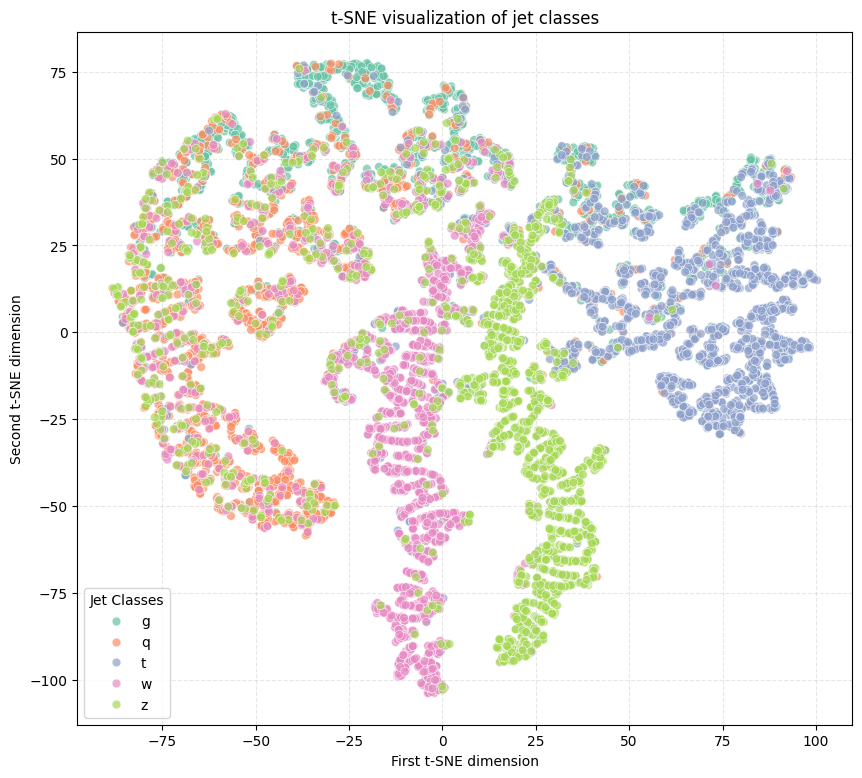

In [ ]:
from sklearn.manifold import TSNE

df = x.copy()
df["class"] = y

# t-SNE is computationally heavy, so we will use a sample of jets: 2000 jets per class
jet_sample = df.groupby("class", group_keys=False).sample(n=2000, random_state=42)

features = jet_sample.drop(columns="class", axis=1).values
labels = jet_sample["class"].values

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca", random_state=42)
x_tsne = tsne.fit_transform(features)

df_tsne = pd.DataFrame(x_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["class"] = labels

plt.figure(figsize=(10,9))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="class", palette="Set2", s=40, alpha=0.7)
plt.xlabel("First t-SNE dimension")
plt.ylabel("Second t-SNE dimension")
plt.title("t-SNE visualization of jet classes")
plt.legend(title="Jet Classes", loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

The target vector is an array of strings because it contains the type of quarks we are interested to know - this is categorical data.  
BDTs and LightGBM work with arrays of strings but it is better to convert them to integers for training and plotting.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# encode string labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# split training and testing datasets: use the same split as done in the reference paper, 60% for training, 20% for validation, 20% for testing
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=54, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=54, stratify=y_train_val)

In [ ]:
print(y, y.dtype)

[0 3 2 ... 2 1 0] int64


In [ ]:
# check if class balance is maintained after splitting
print(np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

[100275  96640 100711 100249 100125] [33425 32213 33570 33417 33375] [33425 32213 33570 33417 33375]


In [ ]:
# no need to plot for outliers because BDTs handle them well
#sns.pairplot(x_train, kind="scatter")

# 2) **Building the Model**: **LightGBM**

### Define the Model  
When defining the training and validation datasets, LightGBM uses its own internal format, and what is important is that the validation data must be aligned with the training data: this is done by using the training dataset as a reference for the validation dataset definition.   
This ensures that there is no inconsistent processing, ensuring the same feature binning and ordering, and no misalignment issues when boosting.

In [ ]:
import lightgbm as lgb

# create LightGBM datasets for training and testing
train_set = lgb.Dataset(x_train, label=y_train)
val_set = lgb.Dataset(x_val, label=y_val, reference=train_set)

# define the hyperparameters
params= {
    "objective": "multiclass",
    "metric": ["multi_logloss", "multi_error"],
    "boosting_type": "gbdt",
    "num_class": 5,
    "max_depth": 6,
    "num_leaves": 48,   # sometimes suggested to be <= 2^max_depth
    "feature_fraction": 0.8,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "learning_rate": 0.05,
    "lambda_l1": 1.0,
    "lambda_l2": 3.0,
    "min_child_samples": 30,
    "min_split_gain": 0.0,
    "min_data_in_leaf": 20,
    "verbosity": -1,
}

### Train the Model  
The model trains using only the training dataset, and we evaluate and check the performance on both the validation and training in order to monitor if there is overfitting or underfitting.  
The metric used here is multi_logloss and it is recorded for both the training and validation dataset.  

Training until validation scores don't improve for 5 rounds
[5]	training's multi_logloss: 1.23799	training's multi_error: 0.260504	validation's multi_logloss: 1.23945	validation's multi_error: 0.261922
[10]	training's multi_logloss: 1.04168	training's multi_error: 0.254629	validation's multi_logloss: 1.04394	validation's multi_error: 0.255886
[15]	training's multi_logloss: 0.926268	training's multi_error: 0.252572	validation's multi_logloss: 0.929226	validation's multi_error: 0.254084
[20]	training's multi_logloss: 0.850337	training's multi_error: 0.250859	validation's multi_logloss: 0.853841	validation's multi_error: 0.252229
[25]	training's multi_logloss: 0.799574	training's multi_error: 0.249265	validation's multi_logloss: 0.803589	validation's multi_error: 0.251229
[30]	training's multi_logloss: 0.766008	training's multi_error: 0.248309	validation's multi_logloss: 0.770401	validation's multi_error: 0.250066
[35]	training's multi_logloss: 0.741983	training's multi_error: 0.247289	va

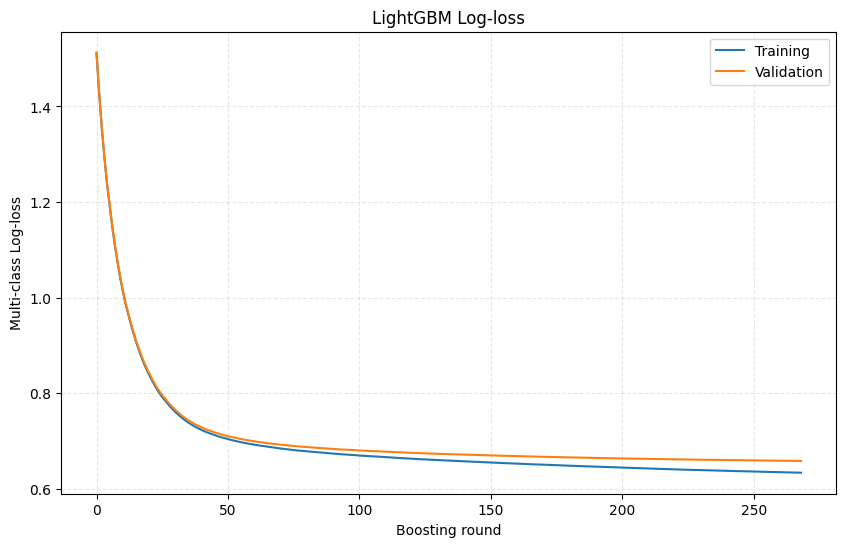

In [ ]:
train_results = {}

callbacks = [
    lgb.early_stopping(stopping_rounds=5),     # help avoiding overfitting and saves time
    lgb.record_evaluation(train_results),    # store training history for plotting
    lgb.log_evaluation(period=5)           # print every 5 rounds
]

bst = lgb.train(params,
                train_set,
                num_boost_round=2000,
                valid_sets=[val_set, train_set],  # evaluate performance on both the validation and training dataset; uses only val_set for early stopping
                valid_names=["validation", "training"],
                callbacks=callbacks,
                )

# plot the performance of both the training and validation to check for overfitting or underfitting
plt.figure(figsize=(10,6))
plt.plot(train_results["training"]["multi_logloss"], label="Training")
plt.plot(train_results["validation"]["multi_logloss"], label="Validation")
plt.xlabel("Boosting round")
plt.ylabel("Multi-class Log-loss")
plt.title("LightGBM Log-loss")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

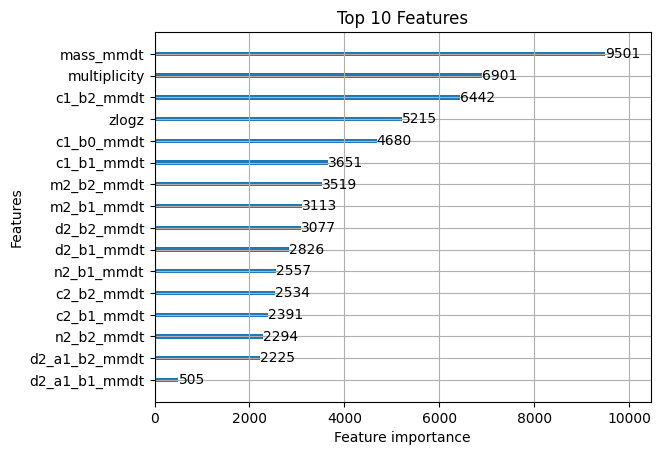

In [ ]:
lgb.plot_importance(bst, max_num_features=16)
plt.title("Top 10 Features")
plt.show()

### Evaluate the Model

#### The metrics used here are the Confusion Matrix, ROC curve and we also plot the LightGBM output.  
We define functions for plotting to keep the code cleaner for further uses.

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# function for plotting the LightGBM output: predicted class probabilities
def output_proba(y_pred_prob, label_encoder, model_name="model"):
  plt.figure(figsize=(10,8))

  for i, class_name in enumerate(label_encoder.classes_):
    plt.hist(y_pred_prob[:,i], bins=100, alpha=0.7, histtype="stepfilled", label=class_name, density=True)

  plt.xlabel("Predicted Probabilities")
  plt.ylabel("Probability Density")
  plt.title(f"{model_name} output: Predicted Class Probabilities")
  plt.legend(loc="best")
  plt.grid(True, linestyle="--", alpha=0.3)
  plt.show()

# function for plotting the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, label_encoder, model_name="model", dataset_name="Validation"):
  cm = confusion_matrix(y_true, y_pred, normalize="true")
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
  im = disp.plot(cmap="Blues", values_format=".2f", colorbar=False)
  cbar = plt.colorbar(im.im_, ax=plt.gca())
  cbar.set_label("Normalized Confusion Matrix")
  plt.title(f"{model_name} Confusion Matrix, {dataset_name} Dataset")
  plt.show()

# function for plotting the ROC curves: will use the paper style
def plot_roc(y_true, y_pred_prob, label_encoder, model_name="model", dataset_name="Validation"):
  plt.figure(figsize=(10,8))

  # turn the true target vector into one-hot encoded vector becasuse ROC needs binary labels to be computed
  y_true_bin = label_binarize(y_true, classes=np.arange(len(label_encoder.classes_)))

  # compute FPR (background efficiency), TPR (signal efficiency) and AUC
  fpr, tpr, roc_auc = {}, {}, {}
  for i, class_name in enumerate(label_encoder.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], y_pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # plotting
  for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(tpr[i], fpr[i], linewidth=2, label=f"{class_name}-tagger, AUC = {roc_auc[i]*100:.1f}%")

  plt.xlabel("Signal Efficiency")
  #plt.xlim(0,1.0)
  plt.ylabel("Background Efficiency")
  plt.yscale("log")
  plt.title(f"{model_name} Taggers: Mis-identification Rate vs Signal Efficiency, {dataset_name} Dataset")
  plt.legend(loc="best")
  plt.grid(True, linestyle="--", alpha=0.3)
  plt.show()

#### Evaluate the Model on the Validation Dataset

Validation Accuracy: 76.42%.

              precision    recall  f1-score   support

           g       0.71      0.76      0.74     33425
           q       0.59      0.73      0.66     32213
           t       0.83      0.84      0.83     33570
           w       0.85      0.75      0.80     33417
           z       0.91      0.73      0.81     33375

    accuracy                           0.76    166000
   macro avg       0.78      0.76      0.77    166000
weighted avg       0.78      0.76      0.77    166000



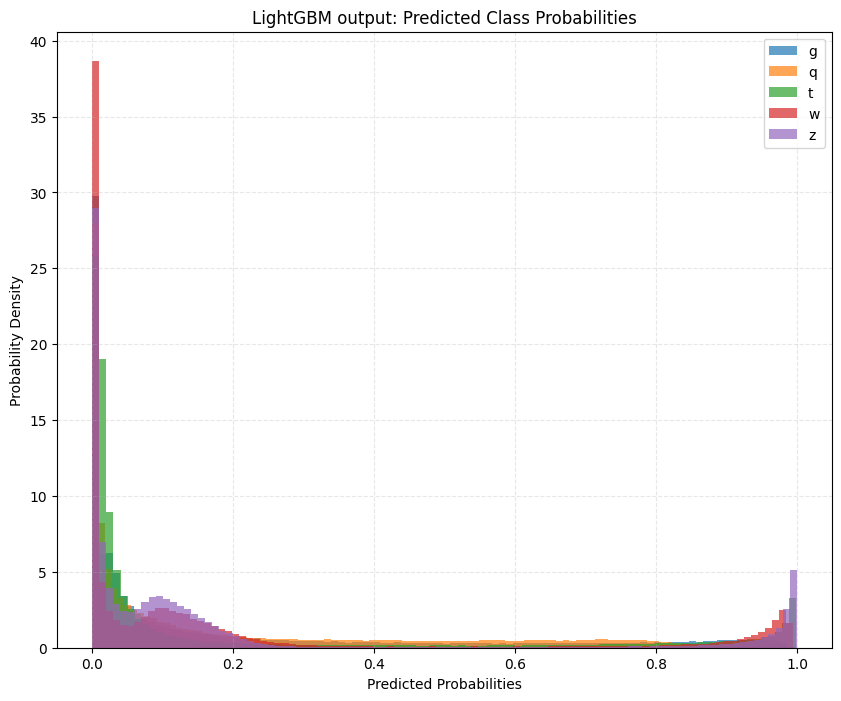

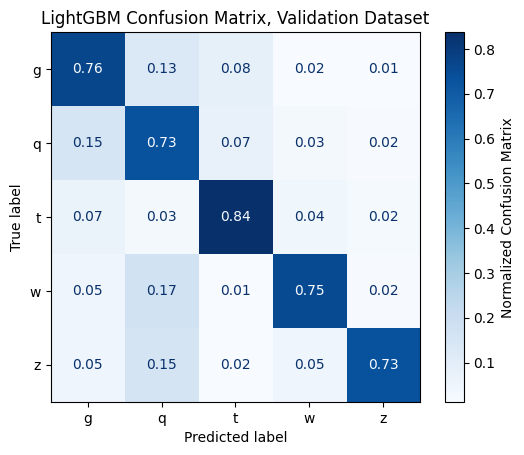

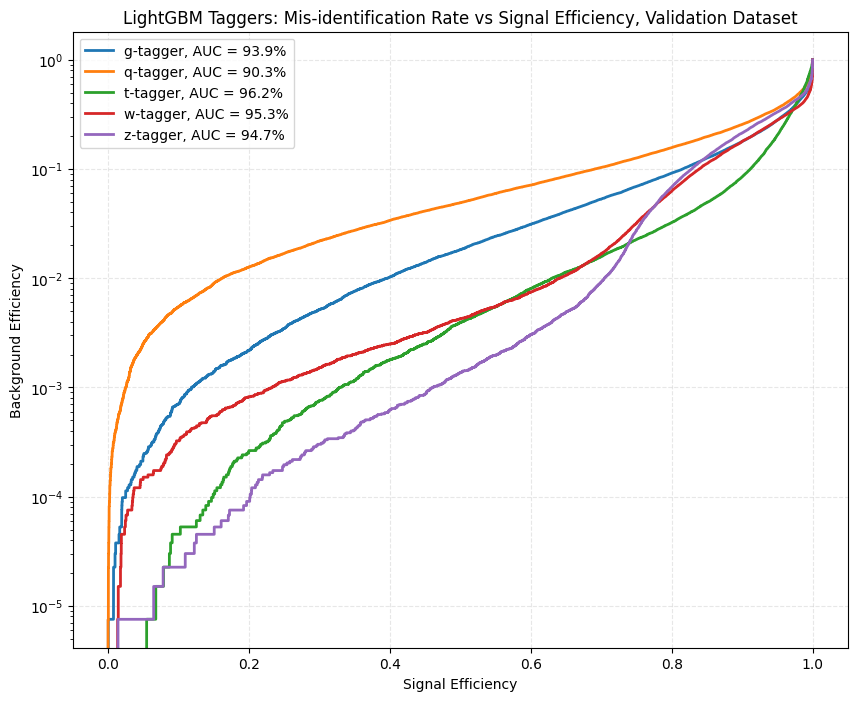

In [ ]:
# predict class probabilities for every jet in the validation dataset using the best iteration picked by early-stopping
y_pred_prob_val = bst.predict(x_val, num_iteration=bst.best_iteration)
# convert probabilities to class labels
y_pred_val = y_pred_prob_val.argmax(axis=1)

# check accuracy and performance
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%.\n")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

# plot LightGBM output
output_proba(y_pred_prob_val, label_encoder, model_name="LightGBM")

# plot confusion matrix
plot_confusion_matrix(y_val, y_pred_val, label_encoder, model_name="LightGBM", dataset_name="Validation")

# plot ROC curves
plot_roc(y_val, y_pred_prob_val, label_encoder, model_name="LightGBM", dataset_name="Validation")

In [ ]:
from threading import Timer

def keep_alive():
    print("Still alive")
    Timer(60, keep_alive).start()

keep_alive()

Still alive


# 2.1) Automated Hyperparameter Tuning Using **Optuna**

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold

def objective(trial):
  param = {
      "objective": "multiclass",
      "metric": "multi_logloss",
      "boosting_type": "gbdt",
      "num_class": 5,
      "max_depth": trial.suggest_int("max_depth", 4, 7),
      "num_leaves": trial.suggest_int("num_leaves", 25, 50),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.8),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.8),
      "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
      "learning_rate": 0.05,
      "lambda_l1": trial.suggest_float("lambda_l1", 0.5, 3.0, step=0.1),
      "lambda_l2": trial.suggest_float("lambda_l2", 1.0, 4.0, step=0.1),
      "min_child_samples": trial.suggest_int("min_child_samples", 20, 40),
      "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),    # minimum gain required to make a split
      "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 40),
      "verbosity": -1,
      "feature_pre_filter": False,
  }

  scores = []
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  for train_idx, val_idx in skf.split(x_train, y_train):
      x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
      y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

      data_train = lgb.Dataset(x_train_fold, label=y_train_fold)
      data_val = lgb.Dataset(x_val_fold, label=y_val_fold, reference=data_train)

      gbm = lgb.train(param,
                      data_train,
                      valid_sets=[data_val],
                      num_boost_round=2000,
                      callbacks=[lgb.early_stopping(5)]
                      )
      scores.append(gbm.best_score["valid_0"]["multi_logloss"])

  return np.mean(scores)

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=10)
print("Best parameters:", study.best_params)

[I 2025-07-31 10:51:09,245] A new study created in memory with name: no-name-04f85c2a-cbf9-4d5c-a029-a2febe4c7712


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[818]	valid_0's multi_logloss: 0.652245
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[864]	valid_0's multi_logloss: 0.648793
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[666]	valid_0's multi_logloss: 0.65071
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[792]	valid_0's multi_logloss: 0.656888
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[678]	valid_0's multi_logloss:

[I 2025-07-31 11:05:48,017] Trial 0 finished with value: 0.6526261250627619 and parameters: {'max_depth': 5, 'num_leaves': 49, 'feature_fraction': 0.746398788362281, 'bagging_fraction': 0.7197316968394073, 'bagging_freq': 1, 'lambda_l1': 0.9, 'lambda_l2': 1.1, 'min_child_samples': 38, 'min_split_gain': 0.6011150117432088, 'min_data_in_leaf': 34}. Best is trial 0 with value: 0.6526261250627619.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1176]	valid_0's multi_logloss: 0.653367
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1211]	valid_0's multi_logloss: 0.649646
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1164]	valid_0's multi_logloss: 0.650751
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1099]	valid_0's multi_logloss: 0.65863
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
S

[I 2025-07-31 11:24:06,385] Trial 1 finished with value: 0.6536750908280152 and parameters: {'max_depth': 4, 'num_leaves': 50, 'feature_fraction': 0.7664885281600844, 'bagging_fraction': 0.6424678221356552, 'bagging_freq': 1, 'lambda_l1': 0.9, 'lambda_l2': 1.9, 'min_child_samples': 31, 'min_split_gain': 0.43194501864211576, 'min_data_in_leaf': 26}. Best is trial 0 with value: 0.6526261250627619.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[724]	valid_0's multi_logloss: 0.651634
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[793]	valid_0's multi_logloss: 0.647834
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[611]	valid_0's multi_logloss: 0.649714
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[795]	valid_0's multi_logloss: 0.655786
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Earl

[I 2025-07-31 11:40:31,307] Trial 2 finished with value: 0.6516154540809816 and parameters: {'max_depth': 6, 'num_leaves': 28, 'feature_fraction': 0.6584289297070436, 'bagging_fraction': 0.6732723686587383, 'bagging_freq': 3, 'lambda_l1': 2.5, 'lambda_l2': 1.6, 'min_child_samples': 30, 'min_split_gain': 0.5924145688620425, 'min_data_in_leaf': 20}. Best is trial 2 with value: 0.6516154540809816.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[724]	valid_0's multi_logloss: 0.652561
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[791]	valid_0's multi_logloss: 0.648884
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[742]	valid_0's multi_logloss: 0.649767
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[796]	valid_0's multi_logloss: 0.656668
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Stil

[I 2025-07-31 11:57:40,828] Trial 3 finished with value: 0.6523982589529467 and parameters: {'max_depth': 6, 'num_leaves': 29, 'feature_fraction': 0.6130103185970559, 'bagging_fraction': 0.7897771074506666, 'bagging_freq': 5, 'lambda_l1': 2.6, 'lambda_l2': 1.9, 'min_child_samples': 22, 'min_split_gain': 0.6842330265121569, 'min_data_in_leaf': 29}. Best is trial 2 with value: 0.6516154540809816.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1123]	valid_0's multi_logloss: 0.654211
Still alive
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1412]	valid_0's multi_logloss: 0.649391
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1337]	valid_0's multi_logloss: 0.650336
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1382]	valid_0's 

[I 2025-07-31 12:22:13,825] Trial 4 finished with value: 0.653132695304488 and parameters: {'max_depth': 4, 'num_leaves': 37, 'feature_fraction': 0.6068777042230437, 'bagging_fraction': 0.7818640804157564, 'bagging_freq': 2, 'lambda_l1': 2.2, 'lambda_l2': 1.9, 'min_child_samples': 30, 'min_split_gain': 0.5467102793432796, 'min_data_in_leaf': 23}. Best is trial 2 with value: 0.6516154540809816.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[523]	valid_0's multi_logloss: 0.650732
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[569]	valid_0's multi_logloss: 0.647206
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[557]	valid_0's multi_logloss: 0.647591
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[439]	valid_0's multi_logloss: 0.656619
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[443]	valid_0's multi_logloss

[I 2025-07-31 12:36:18,801] Trial 5 finished with value: 0.6509902700001949 and parameters: {'max_depth': 7, 'num_leaves': 45, 'feature_fraction': 0.7878997883128378, 'bagging_fraction': 0.7789654700855297, 'bagging_freq': 3, 'lambda_l1': 2.8000000000000003, 'lambda_l2': 1.2, 'min_child_samples': 24, 'min_split_gain': 0.045227288910538066, 'min_data_in_leaf': 26}. Best is trial 5 with value: 0.6509902700001949.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[785]	valid_0's multi_logloss: 0.652103
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[701]	valid_0's multi_logloss: 0.649777
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[889]	valid_0's multi_logloss: 0.648923
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[819]	valid_0's multi_logloss: 0.656332
Still alive
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Stil

[I 2025-07-31 12:53:47,796] Trial 6 finished with value: 0.6521483293015348 and parameters: {'max_depth': 5, 'num_leaves': 32, 'feature_fraction': 0.7657475018303859, 'bagging_fraction': 0.6713506653387179, 'bagging_freq': 2, 'lambda_l1': 1.9000000000000001, 'lambda_l2': 1.4, 'min_child_samples': 36, 'min_split_gain': 0.07455064367977082, 'min_data_in_leaf': 40}. Best is trial 5 with value: 0.6509902700001949.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[618]	valid_0's multi_logloss: 0.651963
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[727]	valid_0's multi_logloss: 0.647722
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[688]	valid_0's multi_logloss: 0.648755
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[676]	valid_0's multi_logloss: 0.656232
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, 

[I 2025-07-31 13:09:27,472] Trial 7 finished with value: 0.651551669237206 and parameters: {'max_depth': 7, 'num_leaves': 30, 'feature_fraction': 0.6011044234247205, 'bagging_fraction': 0.7630922856909669, 'bagging_freq': 4, 'lambda_l1': 2.3, 'lambda_l2': 3.3000000000000003, 'min_child_samples': 21, 'min_split_gain': 0.3584657285442726, 'min_data_in_leaf': 22}. Best is trial 5 with value: 0.6509902700001949.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[556]	valid_0's multi_logloss: 0.652228
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[548]	valid_0's multi_logloss: 0.648933
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[658]	valid_0's multi_logloss: 0.648316
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[588]	valid_0's multi_logloss: 0.656373
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[587]	valid_0's multi_logloss

[I 2025-07-31 13:24:01,012] Trial 8 finished with value: 0.6517668965174337 and parameters: {'max_depth': 7, 'num_leaves': 41, 'feature_fraction': 0.6661796049705299, 'bagging_fraction': 0.6127116700572047, 'bagging_freq': 2, 'lambda_l1': 1.3, 'lambda_l2': 3.2, 'min_child_samples': 33, 'min_split_gain': 0.8872127425763265, 'min_data_in_leaf': 29}. Best is trial 5 with value: 0.6509902700001949.


Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1112]	valid_0's multi_logloss: 0.65401
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1168]	valid_0's multi_logloss: 0.65014
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[1295]	valid_0's multi_logloss: 0.650033
Training until validation scores don't improve for 5 rounds
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Still alive
Early stopping, best iteration is:
[891]	valid_0's multi_logloss: 0.660399
Training until validation s

[I 2025-07-31 13:45:23,012] Trial 9 finished with value: 0.6539701323328285 and parameters: {'max_depth': 4, 'num_leaves': 43, 'feature_fraction': 0.7521570097233795, 'bagging_fraction': 0.7122554395138992, 'bagging_freq': 4, 'lambda_l1': 1.7000000000000002, 'lambda_l2': 2.6, 'min_child_samples': 28, 'min_split_gain': 0.02541912674409519, 'min_data_in_leaf': 22}. Best is trial 5 with value: 0.6509902700001949.


Best parameters: {'max_depth': 7, 'num_leaves': 45, 'feature_fraction': 0.7878997883128378, 'bagging_fraction': 0.7789654700855297, 'bagging_freq': 3, 'lambda_l1': 2.8000000000000003, 'lambda_l2': 1.2, 'min_child_samples': 24, 'min_split_gain': 0.045227288910538066, 'min_data_in_leaf': 26}


Now we can use the best hyperparameters to train and evaluate the model again.

Training until validation scores don't improve for 5 rounds
[5]	training's multi_logloss: 1.23595	training's multi_error: 0.257398	validation's multi_logloss: 1.23737	validation's multi_error: 0.258476
[10]	training's multi_logloss: 1.03829	training's multi_error: 0.252769	validation's multi_logloss: 1.04054	validation's multi_error: 0.253849
[15]	training's multi_logloss: 0.922202	training's multi_error: 0.250797	validation's multi_logloss: 0.925149	validation's multi_error: 0.251554
[20]	training's multi_logloss: 0.846106	training's multi_error: 0.249408	validation's multi_logloss: 0.849621	validation's multi_error: 0.250386
[25]	training's multi_logloss: 0.795073	training's multi_error: 0.248096	validation's multi_logloss: 0.799175	validation's multi_error: 0.249277
[30]	training's multi_logloss: 0.761387	training's multi_error: 0.247171	validation's multi_logloss: 0.76585	validation's multi_error: 0.248488
[35]	training's multi_logloss: 0.737556	training's multi_error: 0.246026	val

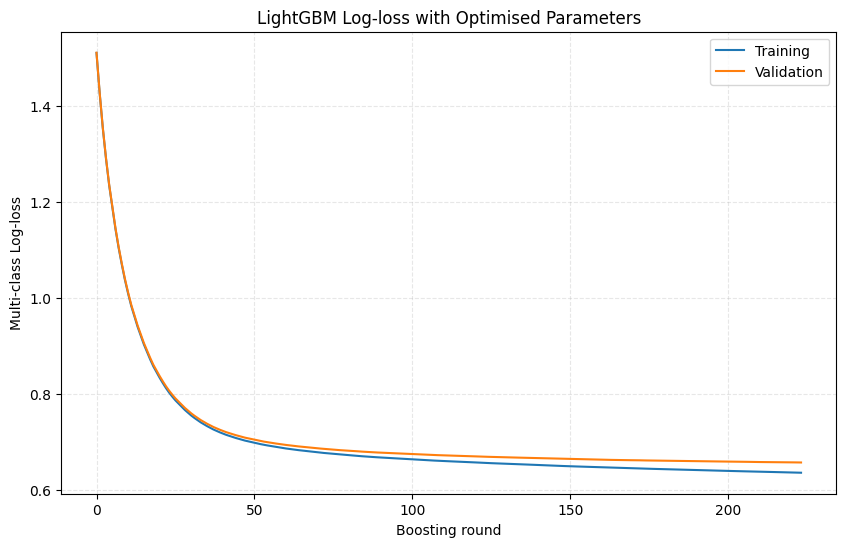

In [ ]:
best_params = study.best_params

best_params.update({
    "objective": "multiclass",
    "metric": ["multi_logloss", "multi_error"],
    "boosting_type": "gbdt",
    "num_class": 5,
    "learning_rate": 0.05,
    "verbosity": -1
})

train_set = lgb.Dataset(x_train, label=y_train)
val_set = lgb.Dataset(x_val, label=y_val, reference=train_set)

opt_results = {}

callbacks_ = [
    lgb.early_stopping(stopping_rounds=5),
    lgb.record_evaluation(opt_results),
    lgb.log_evaluation(period=5)
    ]

gbm_ = lgb.train(best_params,
                 train_set,
                 num_boost_round=2000,
                 valid_sets=[val_set, train_set],
                 valid_names=["validation", "training"],
                 callbacks=callbacks_
                 )

plt.figure(figsize=(10,6))
plt.plot(opt_results["training"]["multi_logloss"], label="Training")
plt.plot(opt_results["validation"]["multi_logloss"], label="Validation")
plt.xlabel("Boosting round")
plt.ylabel("Multi-class Log-loss")
plt.title("LightGBM Log-loss with Optimised Parameters")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

Validation Accuracy: 76.45%.

              precision    recall  f1-score   support

           g       0.71      0.76      0.74     33425
           q       0.59      0.73      0.66     32213
           t       0.83      0.84      0.83     33570
           w       0.85      0.75      0.80     33417
           z       0.92      0.73      0.81     33375

    accuracy                           0.76    166000
   macro avg       0.78      0.76      0.77    166000
weighted avg       0.78      0.76      0.77    166000

Still alive


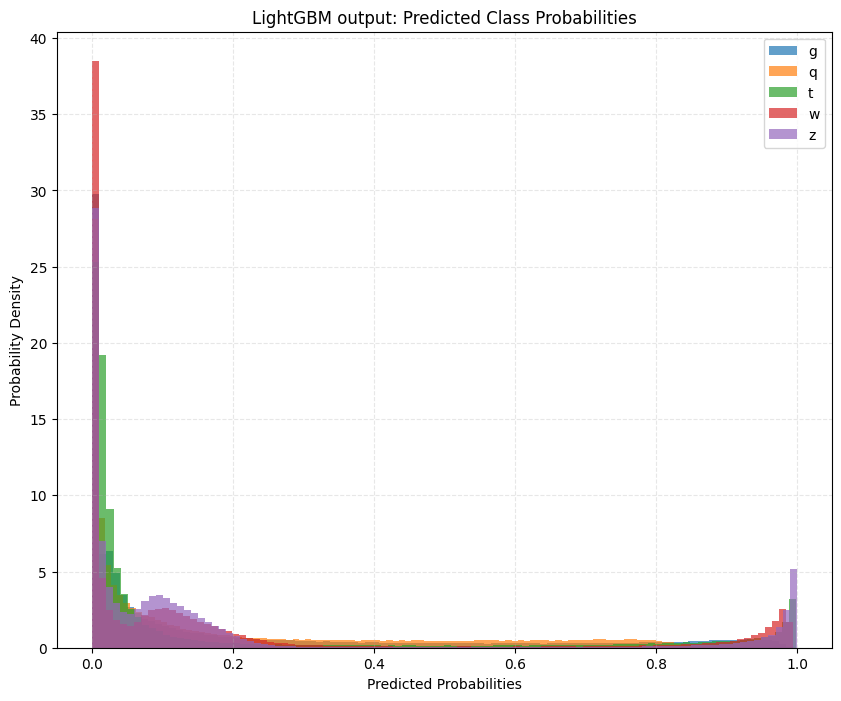

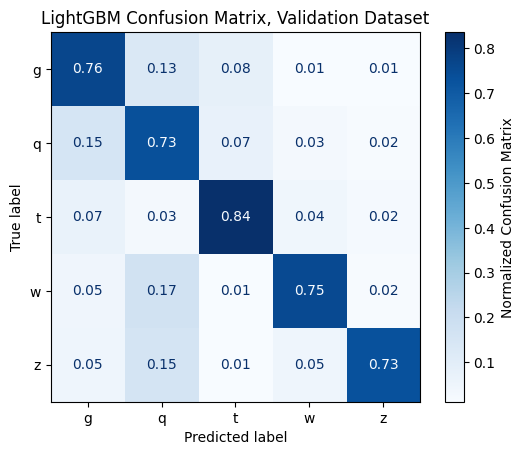

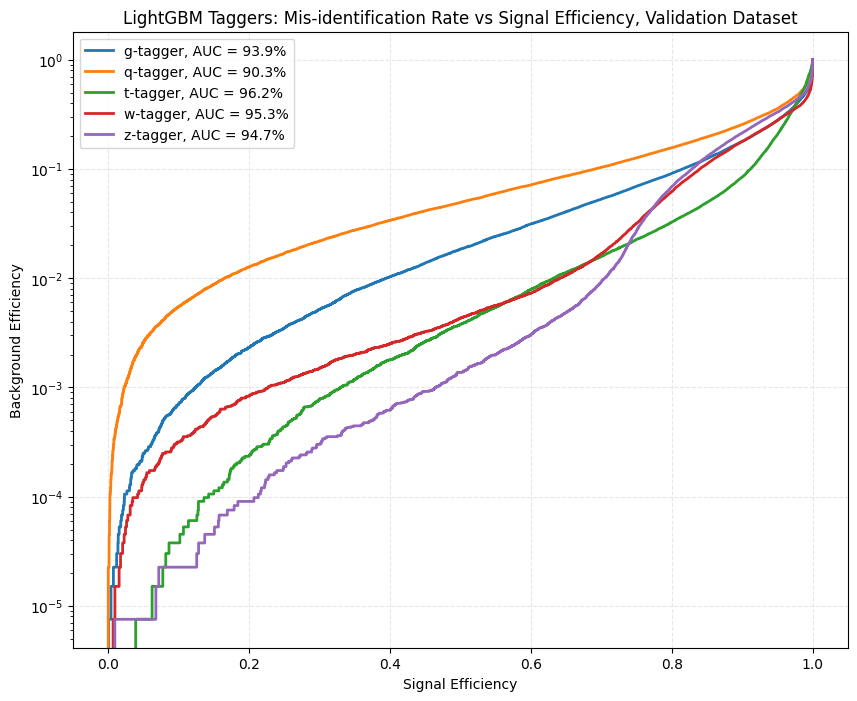

In [ ]:
# predict class probabilities for every jet in the validation dataset using the best iteration picked by early-stopping
y_pred_prob_val = gbm_.predict(x_val, num_iteration=gbm_.best_iteration)
# convert probabilities to class labels
y_pred_val = y_pred_prob_val.argmax(axis=1)

# check accuracy and performance
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%.\n")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

# plot LightGBM output
output_proba(y_pred_prob_val, label_encoder, model_name="LightGBM")

# plot confusion matrix
plot_confusion_matrix(y_val, y_pred_val, label_encoder, model_name="LightGBM", dataset_name="Validation")

# plot ROC curves
plot_roc(y_val, y_pred_prob_val, label_encoder, model_name="LightGBM", dataset_name="Validation")

### Evaluate on the Test Dataset

Still alive
Test Dataset Accuracy: 76.49%
              precision    recall  f1-score   support

           g       0.71      0.76      0.74     33425
           q       0.59      0.74      0.66     32213
           t       0.83      0.83      0.83     33570
           w       0.85      0.75      0.80     33417
           z       0.92      0.74      0.82     33375

    accuracy                           0.76    166000
   macro avg       0.78      0.76      0.77    166000
weighted avg       0.78      0.76      0.77    166000



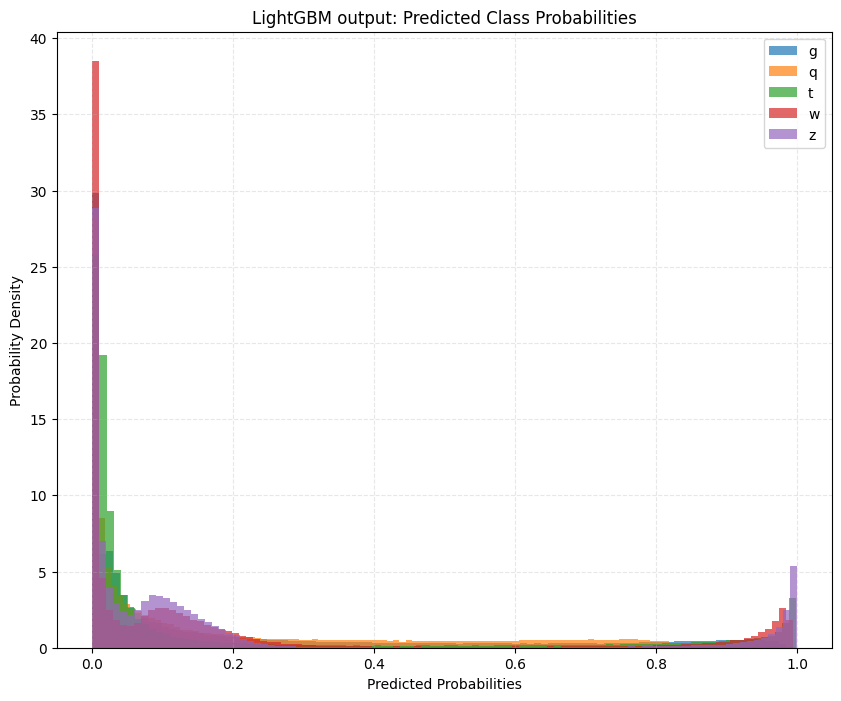

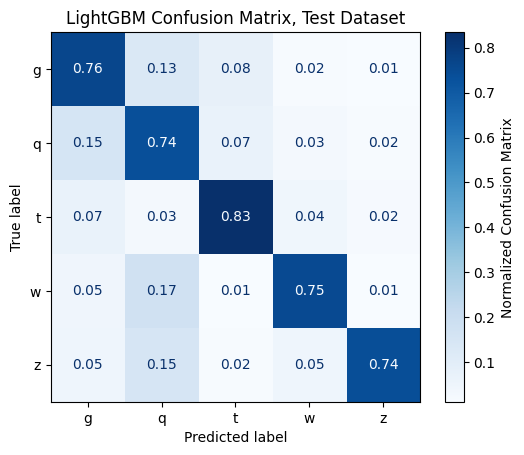

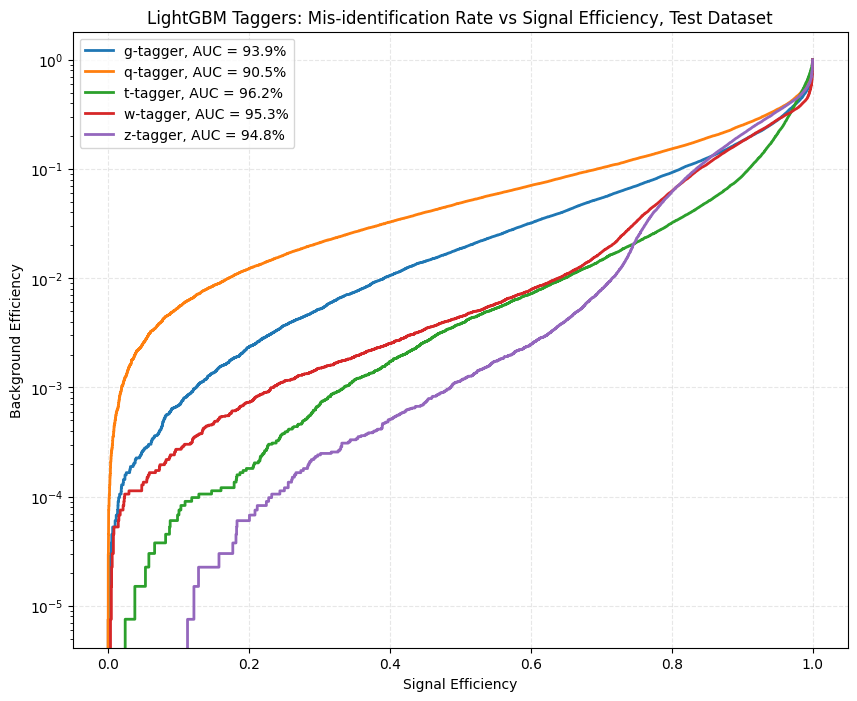

In [ ]:
# make a prediction on the test dataset
y_pred_prob_test = gbm_.predict(x_test, num_interation=gbm_.best_iteration)
y_pred_test = y_pred_prob_test.argmax(axis=1)

# calculate the accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Dataset Accuracy: {accuracy_test*100:.2f}%")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

# plot LightGBM output
output_proba(y_pred_prob_test, label_encoder, model_name="LightGBM")

# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_test, label_encoder, model_name="LightGBM", dataset_name="Test")

# plot ROC
plot_roc(y_test, y_pred_prob_test, label_encoder, model_name="LightGBM", dataset_name="Test")

In [ ]:
import optuna.visualization as vis

vis.plot_param_importances(study)

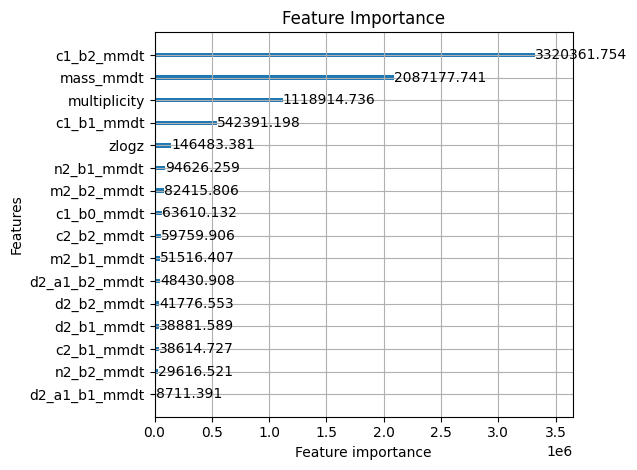

In [ ]:
lgb.plot_importance(gbm_, max_num_features=16, importance_type="gain")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# 3) **Try different classifiers:**  
Here we explored 2 other classifiers to see how their performance compares with LightGBM

# 3.1) **XGBoost**

### Define the Model  

In [ ]:
import xgboost
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

xgb_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=5,
    max_depth=6,
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,          # L1 regularization
    reg_lambda=2.0,         # L2 regularization
    use_label_encoder=False,
    verbosity=1,
    random_state=42,
    early_stopping_rounds=5
)

### Train the Model

In [ ]:
xgb_model.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    verbose=50
)

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:22:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54675
[50]	validation_0-mlogloss:0.76325
[100]	validation_0-mlogloss:0.69834
[150]	validation_0-mlogloss:0.68218
[200]	validation_0-mlogloss:0.67463
[250]	validation_0-mlogloss:0.66882
[300]	validation_0-mlogloss:0.66428
[350]	validation_0-mlogloss:0.66127
[400]	validation_0-mlogloss:0.65915
[450]	validation_0-mlogloss:0.65745
[500]	validation_0-mlogloss:0.65604
[550]	validation_0-mlogloss:0.65503
[600]	validation_0-mlogloss:0.65417
[650]	validation_0-mlogloss:0.65350
[700]	validation_0-mlogloss:0.65294
[750]	validation_0-mlogloss:0.65245
[800]	validation_0-mlogloss:0.65199
[850]	validation_0-mlogloss:0.65165
[900]	validation_0-mlogloss:0.65138
[950]	validation_0-mlogloss:0.65104
[1000]	validation_0-mlogloss:0.65079
[1050]	validation_0-mlogloss:0.65053
[1065]	validation_0-mlogloss:0.65047


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None, num_class=5, ...)

Still alive
Validation Accuracy: 76.64%.

              precision    recall  f1-score   support

           g       0.72      0.77      0.74     33425
           q       0.60      0.73      0.66     32213
           t       0.83      0.84      0.83     33570
           w       0.85      0.76      0.80     33417
           z       0.91      0.73      0.81     33375

    accuracy                           0.77    166000
   macro avg       0.78      0.77      0.77    166000
weighted avg       0.78      0.77      0.77    166000



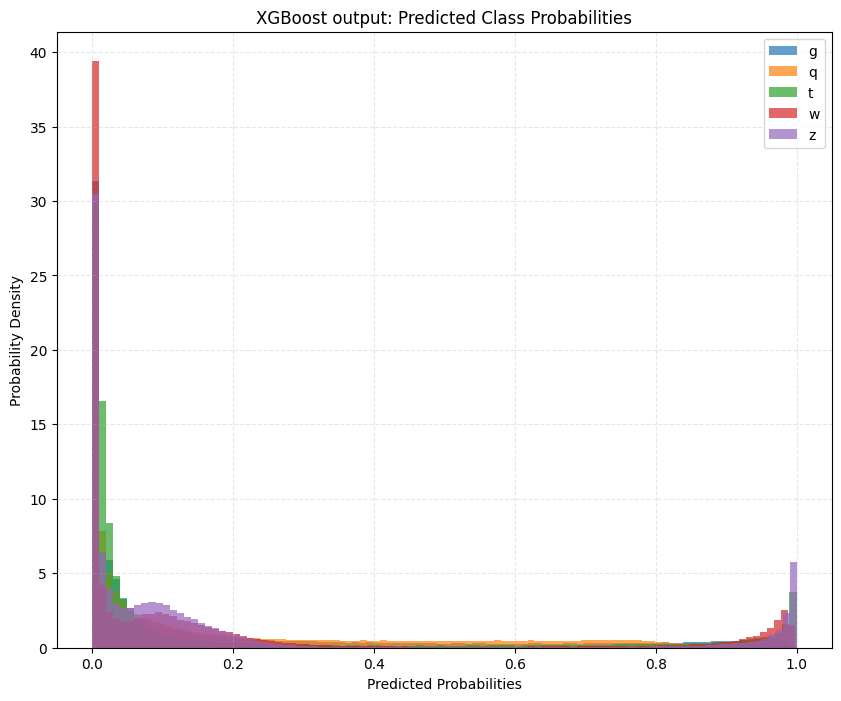

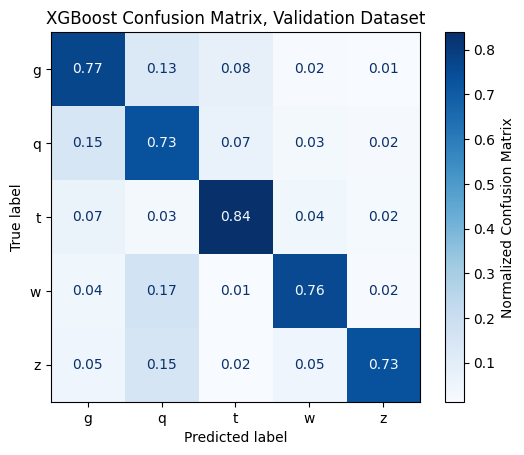

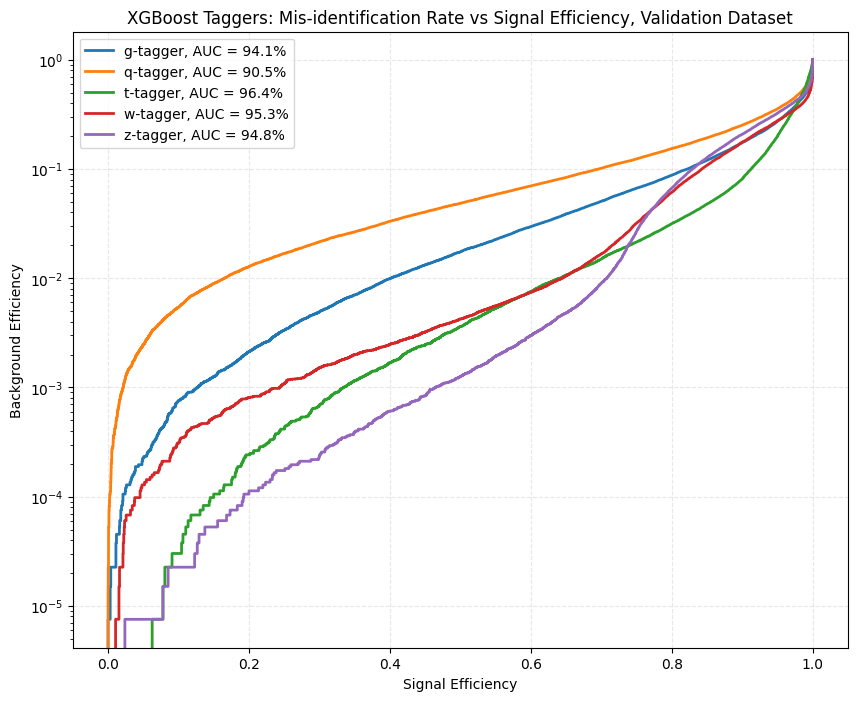

In [ ]:
# predict on validation set
y_pred_prob_val_xg = xgb_model.predict_proba(x_val)
y_pred_val_xg = y_pred_prob_val_xg.argmax(axis=1)

# check accuracy and performance
accuracy = accuracy_score(y_val, y_pred_val_xg)
print(f"Validation Accuracy: {accuracy*100:.2f}%.\n")
print(classification_report(y_val, y_pred_val_xg, target_names=label_encoder.classes_))

# plot XGBoost output
output_proba(y_pred_prob_val_xg, label_encoder, model_name="XGBoost")

# plot confusion matrix
plot_confusion_matrix(y_val, y_pred_val_xg, label_encoder, model_name="XGBoost", dataset_name="Validation")

# plot ROC curves
plot_roc(y_val, y_pred_prob_val_xg, label_encoder, model_name="XGBoost", dataset_name="Validation")

In [ ]:
from threading import Timer

def keep_alive():
    print("Still alive")
    Timer(60, keep_alive).start()

keep_alive()

Still alive


# 3.1.1) Automated Hyperparameter Tuning Using **Optuna**, XGBoost

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    param = {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 5,
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": 0.05,
        "n_estimators": 2000,
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0, step=0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 1,
        "use_label_encoder": False,
        "random_state": 42,
    }

    scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(x_train, y_train):
        x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        xgb = XGBClassifier(**param, early_stopping_rounds=5)
        xgb.fit(
            x_train_fold,
            y_train_fold,
            eval_set=[(x_val_fold, y_val_fold)],
            verbose=50,
        )

        scores.append(log_loss(y_val_fold, xgb.predict_proba(x_val_fold)))

    return np.mean(scores)

study_xgb = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study_xgb.optimize(objective, n_trials=10)
print("Best parameters:", study_xgb.best_params)

[I 2025-07-31 06:29:01,698] A new study created in memory with name: no-name-956d4b06-260c-4240-b024-d58837e44cf1
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:29:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54648
[50]	validation_0-mlogloss:0.75683
[100]	validation_0-mlogloss:0.69555
[150]	validation_0-mlogloss:0.68080
Still alive
[200]	validation_0-mlogloss:0.67396
[250]	validation_0-mlogloss:0.66840
[300]	validation_0-mlogloss:0.66457
[350]	validation_0-mlogloss:0.66153
Still alive
[400]	validation_0-mlogloss:0.65943
[450]	validation_0-mlogloss:0.65781
[500]	validation_0-mlogloss:0.65658
[550]	validation_0-mlogloss:0.65570
[600]	validation_0-mlogloss:0.65487
Still alive
[650]	validation_0-mlogloss:0.65425
[700]	validation_0-mlogloss:0.65365
[750]	validation_0-mlogloss:0.65317
[800]	validation_0-mlogloss:0.65285
[850]	validation_0-mlogloss:0.65254
Still alive
[900]	validation_0-mlogloss:0.65223
[918]	validation_0-mlogloss:0.65214


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:33:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54631
[50]	validation_0-mlogloss:0.75496
Still alive
[100]	validation_0-mlogloss:0.69310
[150]	validation_0-mlogloss:0.67836
[200]	validation_0-mlogloss:0.67157
[250]	validation_0-mlogloss:0.66572
Still alive
[300]	validation_0-mlogloss:0.66181
[350]	validation_0-mlogloss:0.65909
[400]	validation_0-mlogloss:0.65677
[450]	validation_0-mlogloss:0.65525
[500]	validation_0-mlogloss:0.65394
Still alive
[550]	validation_0-mlogloss:0.65290
[600]	validation_0-mlogloss:0.65207
[650]	validation_0-mlogloss:0.65132
[700]	validation_0-mlogloss:0.65071
Still alive
[750]	validation_0-mlogloss:0.65013
[800]	validation_0-mlogloss:0.64968
[850]	validation_0-mlogloss:0.64933
[900]	validation_0-mlogloss:0.64902
[950]	validation_0-mlogloss:0.64863
Still alive
[1000]	validation_0-mlogloss:0.64840
[1050]	validation_0-mlogloss:0.64817
[1100]	validation_0-mlogloss:0.64796
[1104]	validation_0-mlogloss:0.64797


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:38:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54643
Still alive
[50]	validation_0-mlogloss:0.75539
[100]	validation_0-mlogloss:0.69364
[150]	validation_0-mlogloss:0.67868
[200]	validation_0-mlogloss:0.67161
Still alive
[250]	validation_0-mlogloss:0.66603
[300]	validation_0-mlogloss:0.66205
[350]	validation_0-mlogloss:0.65881
[400]	validation_0-mlogloss:0.65678
Still alive
[450]	validation_0-mlogloss:0.65521
[500]	validation_0-mlogloss:0.65391
[550]	validation_0-mlogloss:0.65291
[600]	validation_0-mlogloss:0.65213
[650]	validation_0-mlogloss:0.65145
Still alive
[700]	validation_0-mlogloss:0.65095
[750]	validation_0-mlogloss:0.65048
[800]	validation_0-mlogloss:0.65004
[850]	validation_0-mlogloss:0.64972
Still alive
[900]	validation_0-mlogloss:0.64934
[950]	validation_0-mlogloss:0.64909
[987]	validation_0-mlogloss:0.64895


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:43:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54662
[50]	validation_0-mlogloss:0.76155
Still alive
[100]	validation_0-mlogloss:0.70093
[150]	validation_0-mlogloss:0.68626
[200]	validation_0-mlogloss:0.67909
[250]	validation_0-mlogloss:0.67355
Still alive
[300]	validation_0-mlogloss:0.66943
[350]	validation_0-mlogloss:0.66658
[400]	validation_0-mlogloss:0.66450
[450]	validation_0-mlogloss:0.66293
Still alive
[500]	validation_0-mlogloss:0.66170
[550]	validation_0-mlogloss:0.66075
[600]	validation_0-mlogloss:0.65988
[650]	validation_0-mlogloss:0.65931
[700]	validation_0-mlogloss:0.65879
Still alive
[750]	validation_0-mlogloss:0.65827
[800]	validation_0-mlogloss:0.65792
[850]	validation_0-mlogloss:0.65756
[900]	validation_0-mlogloss:0.65725
[950]	validation_0-mlogloss:0.65705
Still alive
[1000]	validation_0-mlogloss:0.65686
[1050]	validation_0-mlogloss:0.65661
[1100]	validation_0-mlogloss:0.65648
[1121]	validation_0-mlogloss:0.65645
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54643
[50]	validation_0-mlogloss:0.75726
[100]	validation_0-mlogloss:0.69657
[150]	validation_0-mlogloss:0.68219
Still alive
[200]	validation_0-mlogloss:0.67535
[250]	validation_0-mlogloss:0.66983
[300]	validation_0-mlogloss:0.66593
[350]	validation_0-mlogloss:0.66310
[400]	validation_0-mlogloss:0.66125
Still alive
[450]	validation_0-mlogloss:0.65966
[500]	validation_0-mlogloss:0.65839
[550]	validation_0-mlogloss:0.65752
[600]	validation_0-mlogloss:0.65665
Still alive
[650]	validation_0-mlogloss:0.65600
[700]	validation_0-mlogloss:0.65535
[750]	validation_0-mlogloss:0.65487
[800]	validation_0-mlogloss:0.65455
[850]	validation_0-mlogloss:0.65411
Still alive
[900]	validation_0-mlogloss:0.65379
[950]	validation_0-mlogloss:0.65349
[1000]	validation_0-mlogloss:0.65329
[1050]	validation_0-mlogloss:0.65308
Still alive
[1100]	validation_0-mlogloss:0.65288
[1148]	validation_0-mlogloss:0.65269


[I 2025-07-31 06:54:30,586] Trial 0 finished with value: 0.6516353615611663 and parameters: {'max_depth': 6, 'subsample': 0.9852142919229748, 'colsample_bytree': 0.9195981825434215, 'reg_alpha': 1.8, 'reg_lambda': 0.4, 'min_child_weight': 32}. Best is trial 0 with value: 0.6516353615611663.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [06:54:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54999
[50]	validation_0-mlogloss:0.78986
[100]	validation_0-mlogloss:0.72400
Still alive
[150]	validation_0-mlogloss:0.70651
[200]	validation_0-mlogloss:0.69698
[250]	validation_0-mlogloss:0.69024
[300]	validation_0-mlogloss:0.68560
[350]	validation_0-mlogloss:0.68152
Still alive
[400]	validation_0-mlogloss:0.67788
[450]	validation_0-mlogloss:0.67512
[500]	validation_0-mlogloss:0.67261
[550]	validation_0-mlogloss:0.67057
[600]	validation_0-mlogloss:0.66898
Still alive
[650]	validation_0-mlogloss:0.66755
[700]	validation_0-mlogloss:0.66625
[750]	validation_0-mlogloss:0.66517
[800]	validation_0-mlogloss:0.66427
[850]	validation_0-mlogloss:0.66337
[900]	validation_0-mlogloss:0.66259
Still alive
[950]	validation_0-mlogloss:0.66193
[1000]	validation_0-mlogloss:0.66130
[1050]	validation_0-mlogloss:0.66072
[1100]	validation_0-mlogloss:0.66014
[1150]	validation_0-mlogloss:0.65960
[1200]	validation_0-mlogloss:0.65908
Still alive
[1250]	validation_0-mlogloss:0.65862
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:02:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54995
[50]	validation_0-mlogloss:0.78791
[100]	validation_0-mlogloss:0.72162
[150]	validation_0-mlogloss:0.70374
[200]	validation_0-mlogloss:0.69437
Still alive
[250]	validation_0-mlogloss:0.68791
[300]	validation_0-mlogloss:0.68294
[350]	validation_0-mlogloss:0.67878
[400]	validation_0-mlogloss:0.67486
[450]	validation_0-mlogloss:0.67199
Still alive
[500]	validation_0-mlogloss:0.66967
[550]	validation_0-mlogloss:0.66767
[600]	validation_0-mlogloss:0.66605
[650]	validation_0-mlogloss:0.66464
[700]	validation_0-mlogloss:0.66335
[750]	validation_0-mlogloss:0.66207
Still alive
[800]	validation_0-mlogloss:0.66105
[850]	validation_0-mlogloss:0.66009
[900]	validation_0-mlogloss:0.65925
[950]	validation_0-mlogloss:0.65845
[1000]	validation_0-mlogloss:0.65769
Still alive
[1050]	validation_0-mlogloss:0.65696
[1100]	validation_0-mlogloss:0.65640
[1150]	validation_0-mlogloss:0.65590
[1200]	validation_0-mlogloss:0.65538
[1250]	validation_0-mlogloss:0.65492
[1300]	valida

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:09:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55045
[50]	validation_0-mlogloss:0.78868
Still alive
[100]	validation_0-mlogloss:0.72256
[150]	validation_0-mlogloss:0.70468
[200]	validation_0-mlogloss:0.69564
[250]	validation_0-mlogloss:0.68874
[300]	validation_0-mlogloss:0.68382
Still alive
[350]	validation_0-mlogloss:0.67945
[400]	validation_0-mlogloss:0.67606
[450]	validation_0-mlogloss:0.67302
[500]	validation_0-mlogloss:0.67040
[550]	validation_0-mlogloss:0.66838
Still alive
[600]	validation_0-mlogloss:0.66668
[650]	validation_0-mlogloss:0.66526
[700]	validation_0-mlogloss:0.66404
[750]	validation_0-mlogloss:0.66281
[800]	validation_0-mlogloss:0.66186
[850]	validation_0-mlogloss:0.66095
Still alive
[900]	validation_0-mlogloss:0.66001
[950]	validation_0-mlogloss:0.65931
[1000]	validation_0-mlogloss:0.65855
[1050]	validation_0-mlogloss:0.65784
[1100]	validation_0-mlogloss:0.65726
Still alive
[1150]	validation_0-mlogloss:0.65675
[1200]	validation_0-mlogloss:0.65622
[1250]	validation_0-mlogloss:0.65580
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:17:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55069
[50]	validation_0-mlogloss:0.79462
[100]	validation_0-mlogloss:0.72935
Still alive
[150]	validation_0-mlogloss:0.71221
[200]	validation_0-mlogloss:0.70243
[250]	validation_0-mlogloss:0.69573
[300]	validation_0-mlogloss:0.69073
[350]	validation_0-mlogloss:0.68649
[400]	validation_0-mlogloss:0.68287
Still alive
[450]	validation_0-mlogloss:0.68015
[500]	validation_0-mlogloss:0.67761
[550]	validation_0-mlogloss:0.67560
[600]	validation_0-mlogloss:0.67377
[650]	validation_0-mlogloss:0.67230
Still alive
[700]	validation_0-mlogloss:0.67105
[750]	validation_0-mlogloss:0.66996
[800]	validation_0-mlogloss:0.66889
[850]	validation_0-mlogloss:0.66788
[900]	validation_0-mlogloss:0.66716
[950]	validation_0-mlogloss:0.66638
Still alive
[1000]	validation_0-mlogloss:0.66579
[1050]	validation_0-mlogloss:0.66514
[1100]	validation_0-mlogloss:0.66454
[1150]	validation_0-mlogloss:0.66401
[1200]	validation_0-mlogloss:0.66357
Still alive
[1250]	validation_0-mlogloss:0.66314
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:25:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55009
[50]	validation_0-mlogloss:0.79053
[100]	validation_0-mlogloss:0.72492
[150]	validation_0-mlogloss:0.70716
[200]	validation_0-mlogloss:0.69812
Still alive
[250]	validation_0-mlogloss:0.69157
[300]	validation_0-mlogloss:0.68663
[350]	validation_0-mlogloss:0.68215
[400]	validation_0-mlogloss:0.67922
[450]	validation_0-mlogloss:0.67625
[500]	validation_0-mlogloss:0.67371
Still alive
[550]	validation_0-mlogloss:0.67208
[600]	validation_0-mlogloss:0.67040
[650]	validation_0-mlogloss:0.66871
[700]	validation_0-mlogloss:0.66736
[750]	validation_0-mlogloss:0.66608
Still alive
[800]	validation_0-mlogloss:0.66512
[850]	validation_0-mlogloss:0.66426
[900]	validation_0-mlogloss:0.66348
[950]	validation_0-mlogloss:0.66278
[1000]	validation_0-mlogloss:0.66212
[1050]	validation_0-mlogloss:0.66155
Still alive
[1100]	validation_0-mlogloss:0.66099
[1150]	validation_0-mlogloss:0.66053
[1200]	validation_0-mlogloss:0.66000
[1250]	validation_0-mlogloss:0.65959
[1300]	valida

[I 2025-07-31 07:32:38,551] Trial 1 finished with value: 0.6541256144395986 and parameters: {'max_depth': 4, 'subsample': 0.9598528437324805, 'colsample_bytree': 0.8803345035229626, 'reg_alpha': 2.1, 'reg_lambda': 0.0, 'min_child_weight': 98}. Best is trial 0 with value: 0.6516353615611663.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:32:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54415
Still alive
[50]	validation_0-mlogloss:0.73697
[100]	validation_0-mlogloss:0.67515
[150]	validation_0-mlogloss:0.66256
Still alive
[200]	validation_0-mlogloss:0.65781
[250]	validation_0-mlogloss:0.65519
[300]	validation_0-mlogloss:0.65358
[350]	validation_0-mlogloss:0.65241
Still alive
[400]	validation_0-mlogloss:0.65174
[446]	validation_0-mlogloss:0.65123


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:35:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54418
Still alive
[50]	validation_0-mlogloss:0.73586
[100]	validation_0-mlogloss:0.67337
[150]	validation_0-mlogloss:0.66062
Still alive
[200]	validation_0-mlogloss:0.65584
[250]	validation_0-mlogloss:0.65275
[300]	validation_0-mlogloss:0.65095
[350]	validation_0-mlogloss:0.64975
Still alive
[400]	validation_0-mlogloss:0.64890
[450]	validation_0-mlogloss:0.64838
[500]	validation_0-mlogloss:0.64787
[550]	validation_0-mlogloss:0.64741
Still alive
[593]	validation_0-mlogloss:0.64727


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:39:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54426
[50]	validation_0-mlogloss:0.73599
Still alive
[100]	validation_0-mlogloss:0.67347
[150]	validation_0-mlogloss:0.66086
[200]	validation_0-mlogloss:0.65599
Still alive
[250]	validation_0-mlogloss:0.65328
[300]	validation_0-mlogloss:0.65150
[350]	validation_0-mlogloss:0.65032
[400]	validation_0-mlogloss:0.64957
Still alive
[450]	validation_0-mlogloss:0.64884
[500]	validation_0-mlogloss:0.64846
[512]	validation_0-mlogloss:0.64839


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54473
Still alive
[50]	validation_0-mlogloss:0.74168
[100]	validation_0-mlogloss:0.68045
[150]	validation_0-mlogloss:0.66819
Still alive
[200]	validation_0-mlogloss:0.66331
[250]	validation_0-mlogloss:0.66055
[300]	validation_0-mlogloss:0.65902
Still alive
[350]	validation_0-mlogloss:0.65764
[400]	validation_0-mlogloss:0.65688
[450]	validation_0-mlogloss:0.65635
[494]	validation_0-mlogloss:0.65603
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:46:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54439
[50]	validation_0-mlogloss:0.73833
[100]	validation_0-mlogloss:0.67668
Still alive
[150]	validation_0-mlogloss:0.66446
[200]	validation_0-mlogloss:0.65997
[250]	validation_0-mlogloss:0.65714
Still alive
[300]	validation_0-mlogloss:0.65525
[350]	validation_0-mlogloss:0.65415
[400]	validation_0-mlogloss:0.65338
[450]	validation_0-mlogloss:0.65273
Still alive
[500]	validation_0-mlogloss:0.65239
[513]	validation_0-mlogloss:0.65235


[I 2025-07-31 07:49:28,561] Trial 2 finished with value: 0.65103746870527 and parameters: {'max_depth': 9, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'reg_alpha': 0.5, 'reg_lambda': 0.9, 'min_child_weight': 62}. Best is trial 2 with value: 0.65103746870527.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:49:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54534
[50]	validation_0-mlogloss:0.74514
Still alive
[100]	validation_0-mlogloss:0.68480
[150]	validation_0-mlogloss:0.67103
[200]	validation_0-mlogloss:0.66483
[250]	validation_0-mlogloss:0.66058
Still alive
[300]	validation_0-mlogloss:0.65785
[350]	validation_0-mlogloss:0.65598
[400]	validation_0-mlogloss:0.65456
[450]	validation_0-mlogloss:0.65354
Still alive
[500]	validation_0-mlogloss:0.65261
[550]	validation_0-mlogloss:0.65198
[600]	validation_0-mlogloss:0.65150
[650]	validation_0-mlogloss:0.65117
[700]	validation_0-mlogloss:0.65083
Still alive
[750]	validation_0-mlogloss:0.65056
[800]	validation_0-mlogloss:0.65030
[850]	validation_0-mlogloss:0.65010
[885]	validation_0-mlogloss:0.65003
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:54:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54532
[50]	validation_0-mlogloss:0.74362
[100]	validation_0-mlogloss:0.68293
[150]	validation_0-mlogloss:0.66940
Still alive
[200]	validation_0-mlogloss:0.66291
[250]	validation_0-mlogloss:0.65838
[300]	validation_0-mlogloss:0.65560
[350]	validation_0-mlogloss:0.65371
Still alive
[400]	validation_0-mlogloss:0.65210
[450]	validation_0-mlogloss:0.65106
[500]	validation_0-mlogloss:0.65012
[550]	validation_0-mlogloss:0.64943
Still alive
[600]	validation_0-mlogloss:0.64888
[650]	validation_0-mlogloss:0.64839
[700]	validation_0-mlogloss:0.64803
[732]	validation_0-mlogloss:0.64787
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:58:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54550
[50]	validation_0-mlogloss:0.74381
[100]	validation_0-mlogloss:0.68274
[150]	validation_0-mlogloss:0.66892
Still alive
[200]	validation_0-mlogloss:0.66278
[250]	validation_0-mlogloss:0.65849
[300]	validation_0-mlogloss:0.65547
[350]	validation_0-mlogloss:0.65345
Still alive
[400]	validation_0-mlogloss:0.65213
[450]	validation_0-mlogloss:0.65091
[500]	validation_0-mlogloss:0.65006
[550]	validation_0-mlogloss:0.64947
Still alive
[600]	validation_0-mlogloss:0.64892
[650]	validation_0-mlogloss:0.64851
[700]	validation_0-mlogloss:0.64814
[750]	validation_0-mlogloss:0.64782
Still alive
[800]	validation_0-mlogloss:0.64749
[850]	validation_0-mlogloss:0.64723
[884]	validation_0-mlogloss:0.64708


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:02:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54577
Still alive
[50]	validation_0-mlogloss:0.75017
[100]	validation_0-mlogloss:0.69047
[150]	validation_0-mlogloss:0.67683
[200]	validation_0-mlogloss:0.67045
Still alive
[250]	validation_0-mlogloss:0.66606
[300]	validation_0-mlogloss:0.66326
[350]	validation_0-mlogloss:0.66114
[400]	validation_0-mlogloss:0.65981
Still alive
[450]	validation_0-mlogloss:0.65875
[500]	validation_0-mlogloss:0.65806
[550]	validation_0-mlogloss:0.65743
[600]	validation_0-mlogloss:0.65693
Still alive
[650]	validation_0-mlogloss:0.65652
[700]	validation_0-mlogloss:0.65621
[730]	validation_0-mlogloss:0.65613


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:06:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54549
Still alive
[50]	validation_0-mlogloss:0.74592
[100]	validation_0-mlogloss:0.68596
[150]	validation_0-mlogloss:0.67285
[200]	validation_0-mlogloss:0.66654
Still alive
[250]	validation_0-mlogloss:0.66248
[300]	validation_0-mlogloss:0.65965
[350]	validation_0-mlogloss:0.65762
[400]	validation_0-mlogloss:0.65626
Still alive
[450]	validation_0-mlogloss:0.65513
[500]	validation_0-mlogloss:0.65438
[550]	validation_0-mlogloss:0.65379
[600]	validation_0-mlogloss:0.65327
Still alive
[650]	validation_0-mlogloss:0.65283
[700]	validation_0-mlogloss:0.65245
[750]	validation_0-mlogloss:0.65209
[770]	validation_0-mlogloss:0.65197


[I 2025-07-31 08:11:02,333] Trial 3 finished with value: 0.6506101349107059 and parameters: {'max_depth': 7, 'subsample': 0.7873687420594125, 'colsample_bytree': 0.8835558684167139, 'reg_alpha': 0.4, 'reg_lambda': 0.9, 'min_child_weight': 49}. Best is trial 3 with value: 0.6506101349107059.


Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:11:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54556
[50]	validation_0-mlogloss:0.75150
[100]	validation_0-mlogloss:0.68797
[150]	validation_0-mlogloss:0.67299
Still alive
[200]	validation_0-mlogloss:0.66646
[250]	validation_0-mlogloss:0.66179
[300]	validation_0-mlogloss:0.65877
[350]	validation_0-mlogloss:0.65670
Still alive
[400]	validation_0-mlogloss:0.65530
[450]	validation_0-mlogloss:0.65407
[500]	validation_0-mlogloss:0.65322
[550]	validation_0-mlogloss:0.65255
Still alive
[600]	validation_0-mlogloss:0.65216
[650]	validation_0-mlogloss:0.65170
[700]	validation_0-mlogloss:0.65138
[750]	validation_0-mlogloss:0.65110
[767]	validation_0-mlogloss:0.65101
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:15:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54549
[50]	validation_0-mlogloss:0.74989
[100]	validation_0-mlogloss:0.68566
Still alive
[150]	validation_0-mlogloss:0.67079
[200]	validation_0-mlogloss:0.66453
[250]	validation_0-mlogloss:0.65957
[300]	validation_0-mlogloss:0.65622
Still alive
[350]	validation_0-mlogloss:0.65406
[400]	validation_0-mlogloss:0.65255
[450]	validation_0-mlogloss:0.65137
[500]	validation_0-mlogloss:0.65033
Still alive
[550]	validation_0-mlogloss:0.64960
[600]	validation_0-mlogloss:0.64906
[650]	validation_0-mlogloss:0.64859
[700]	validation_0-mlogloss:0.64824
[719]	validation_0-mlogloss:0.64821
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:19:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54553
[50]	validation_0-mlogloss:0.74986
[100]	validation_0-mlogloss:0.68563
Still alive
[150]	validation_0-mlogloss:0.67080
[200]	validation_0-mlogloss:0.66425
[250]	validation_0-mlogloss:0.65955
[300]	validation_0-mlogloss:0.65654
Still alive
[350]	validation_0-mlogloss:0.65449
[400]	validation_0-mlogloss:0.65276
[450]	validation_0-mlogloss:0.65166
[500]	validation_0-mlogloss:0.65065
Still alive
[550]	validation_0-mlogloss:0.64999
[600]	validation_0-mlogloss:0.64955
[650]	validation_0-mlogloss:0.64908
[700]	validation_0-mlogloss:0.64871
[750]	validation_0-mlogloss:0.64842
Still alive
[780]	validation_0-mlogloss:0.64830


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:23:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54593
[50]	validation_0-mlogloss:0.75615
[100]	validation_0-mlogloss:0.69301
Still alive
[150]	validation_0-mlogloss:0.67830
[200]	validation_0-mlogloss:0.67179
[250]	validation_0-mlogloss:0.66716
Still alive
[300]	validation_0-mlogloss:0.66401
[350]	validation_0-mlogloss:0.66168
[400]	validation_0-mlogloss:0.66015
[450]	validation_0-mlogloss:0.65909
[500]	validation_0-mlogloss:0.65814
Still alive
[550]	validation_0-mlogloss:0.65764
[600]	validation_0-mlogloss:0.65710
[650]	validation_0-mlogloss:0.65667
[700]	validation_0-mlogloss:0.65635
[703]	validation_0-mlogloss:0.65635
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:27:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54560
[50]	validation_0-mlogloss:0.75224
[100]	validation_0-mlogloss:0.68911
Still alive
[150]	validation_0-mlogloss:0.67461
[200]	validation_0-mlogloss:0.66833
[250]	validation_0-mlogloss:0.66381
[300]	validation_0-mlogloss:0.66046
Still alive
[350]	validation_0-mlogloss:0.65851
[400]	validation_0-mlogloss:0.65692
[450]	validation_0-mlogloss:0.65584
[500]	validation_0-mlogloss:0.65501
Still alive
[550]	validation_0-mlogloss:0.65442
[600]	validation_0-mlogloss:0.65386
[650]	validation_0-mlogloss:0.65338
[691]	validation_0-mlogloss:0.65309


[I 2025-07-31 08:30:59,747] Trial 4 finished with value: 0.6513849485718811 and parameters: {'max_depth': 7, 'subsample': 0.935552788417904, 'colsample_bytree': 0.7599021346475079, 'reg_alpha': 1.5, 'reg_lambda': 1.8, 'min_child_weight': 23}. Best is trial 3 with value: 0.6506101349107059.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:31:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54632
Still alive
[50]	validation_0-mlogloss:0.74980
[100]	validation_0-mlogloss:0.68498
[150]	validation_0-mlogloss:0.67063
Still alive
[200]	validation_0-mlogloss:0.66460
[250]	validation_0-mlogloss:0.66054
[300]	validation_0-mlogloss:0.65782
Still alive
[350]	validation_0-mlogloss:0.65613
[400]	validation_0-mlogloss:0.65484
[450]	validation_0-mlogloss:0.65382
[500]	validation_0-mlogloss:0.65309
Still alive
[550]	validation_0-mlogloss:0.65251
[600]	validation_0-mlogloss:0.65208
[650]	validation_0-mlogloss:0.65174
[690]	validation_0-mlogloss:0.65153
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:35:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54618
[50]	validation_0-mlogloss:0.74841
[100]	validation_0-mlogloss:0.68265
Still alive
[150]	validation_0-mlogloss:0.66858
[200]	validation_0-mlogloss:0.66212
[250]	validation_0-mlogloss:0.65808
[300]	validation_0-mlogloss:0.65521
Still alive
[350]	validation_0-mlogloss:0.65323
[400]	validation_0-mlogloss:0.65185
[450]	validation_0-mlogloss:0.65076
Still alive
[500]	validation_0-mlogloss:0.64991
[550]	validation_0-mlogloss:0.64921
[600]	validation_0-mlogloss:0.64871
[650]	validation_0-mlogloss:0.64827
Still alive
[700]	validation_0-mlogloss:0.64797
[717]	validation_0-mlogloss:0.64789


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:39:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54629
[50]	validation_0-mlogloss:0.74865
Still alive
[100]	validation_0-mlogloss:0.68278
[150]	validation_0-mlogloss:0.66846
[200]	validation_0-mlogloss:0.66228
Still alive
[250]	validation_0-mlogloss:0.65820
[300]	validation_0-mlogloss:0.65543
[350]	validation_0-mlogloss:0.65353
[400]	validation_0-mlogloss:0.65223
Still alive
[450]	validation_0-mlogloss:0.65122
[500]	validation_0-mlogloss:0.65041
[550]	validation_0-mlogloss:0.64972
[600]	validation_0-mlogloss:0.64916
Still alive
[650]	validation_0-mlogloss:0.64868
[700]	validation_0-mlogloss:0.64837
[719]	validation_0-mlogloss:0.64832


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:43:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54666
Still alive
[50]	validation_0-mlogloss:0.75468
[100]	validation_0-mlogloss:0.68972
[150]	validation_0-mlogloss:0.67578
Still alive
[200]	validation_0-mlogloss:0.66955
[250]	validation_0-mlogloss:0.66561
[300]	validation_0-mlogloss:0.66301
[350]	validation_0-mlogloss:0.66104
Still alive
[400]	validation_0-mlogloss:0.65970
[450]	validation_0-mlogloss:0.65861
[500]	validation_0-mlogloss:0.65787
Still alive
[550]	validation_0-mlogloss:0.65722
[600]	validation_0-mlogloss:0.65683
[650]	validation_0-mlogloss:0.65642
[700]	validation_0-mlogloss:0.65621
[716]	validation_0-mlogloss:0.65615
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:48:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54633
[50]	validation_0-mlogloss:0.75091
[100]	validation_0-mlogloss:0.68614
Still alive
[150]	validation_0-mlogloss:0.67226
[200]	validation_0-mlogloss:0.66618
[250]	validation_0-mlogloss:0.66224
Still alive
[300]	validation_0-mlogloss:0.65932
[350]	validation_0-mlogloss:0.65742
[400]	validation_0-mlogloss:0.65595
[450]	validation_0-mlogloss:0.65488
Still alive
[500]	validation_0-mlogloss:0.65406
[550]	validation_0-mlogloss:0.65349
[600]	validation_0-mlogloss:0.65306
[650]	validation_0-mlogloss:0.65262
Still alive
[687]	validation_0-mlogloss:0.65245


[I 2025-07-31 08:52:22,444] Trial 5 finished with value: 0.6512627323094135 and parameters: {'max_depth': 8, 'subsample': 0.7511572371061874, 'colsample_bytree': 0.7195154778955838, 'reg_alpha': 2.9000000000000004, 'reg_lambda': 2.9000000000000004, 'min_child_weight': 85}. Best is trial 3 with value: 0.6506101349107059.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:52:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54657
[50]	validation_0-mlogloss:0.75623
[100]	validation_0-mlogloss:0.69505
Still alive
[150]	validation_0-mlogloss:0.68031
[200]	validation_0-mlogloss:0.67324
[250]	validation_0-mlogloss:0.66783
[300]	validation_0-mlogloss:0.66410
Still alive
[350]	validation_0-mlogloss:0.66138
[400]	validation_0-mlogloss:0.65940
[450]	validation_0-mlogloss:0.65785
[500]	validation_0-mlogloss:0.65641
Still alive
[550]	validation_0-mlogloss:0.65543
[600]	validation_0-mlogloss:0.65455
[650]	validation_0-mlogloss:0.65384
[700]	validation_0-mlogloss:0.65312
[750]	validation_0-mlogloss:0.65257
Still alive
[800]	validation_0-mlogloss:0.65213
[850]	validation_0-mlogloss:0.65169
[900]	validation_0-mlogloss:0.65139
[950]	validation_0-mlogloss:0.65102
Still alive
[1000]	validation_0-mlogloss:0.65078
[1028]	validation_0-mlogloss:0.65065


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [08:57:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54634
[50]	validation_0-mlogloss:0.75443
[100]	validation_0-mlogloss:0.69287
Still alive
[150]	validation_0-mlogloss:0.67847
[200]	validation_0-mlogloss:0.67114
[250]	validation_0-mlogloss:0.66562
[300]	validation_0-mlogloss:0.66185
Still alive
[350]	validation_0-mlogloss:0.65887
[400]	validation_0-mlogloss:0.65659
[450]	validation_0-mlogloss:0.65503
[500]	validation_0-mlogloss:0.65362
Still alive
[550]	validation_0-mlogloss:0.65249
[600]	validation_0-mlogloss:0.65170
[650]	validation_0-mlogloss:0.65090
[700]	validation_0-mlogloss:0.65021
[750]	validation_0-mlogloss:0.64963
Still alive
[800]	validation_0-mlogloss:0.64924
[850]	validation_0-mlogloss:0.64888
[900]	validation_0-mlogloss:0.64844
[950]	validation_0-mlogloss:0.64810
Still alive
[1000]	validation_0-mlogloss:0.64777
[1050]	validation_0-mlogloss:0.64751
[1100]	validation_0-mlogloss:0.64728
[1147]	validation_0-mlogloss:0.64707
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:03:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54643
[50]	validation_0-mlogloss:0.75534
[100]	validation_0-mlogloss:0.69306
[150]	validation_0-mlogloss:0.67817
Still alive
[200]	validation_0-mlogloss:0.67122
[250]	validation_0-mlogloss:0.66557
[300]	validation_0-mlogloss:0.66163
[350]	validation_0-mlogloss:0.65883
Still alive
[400]	validation_0-mlogloss:0.65682
[450]	validation_0-mlogloss:0.65524
[500]	validation_0-mlogloss:0.65392
[550]	validation_0-mlogloss:0.65287
[600]	validation_0-mlogloss:0.65193
Still alive
[650]	validation_0-mlogloss:0.65111
[700]	validation_0-mlogloss:0.65039
[750]	validation_0-mlogloss:0.64987
[800]	validation_0-mlogloss:0.64942
Still alive
[850]	validation_0-mlogloss:0.64893
[900]	validation_0-mlogloss:0.64862
[950]	validation_0-mlogloss:0.64830
[1000]	validation_0-mlogloss:0.64801
[1050]	validation_0-mlogloss:0.64775
Still alive
[1080]	validation_0-mlogloss:0.64761


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:08:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54655
[50]	validation_0-mlogloss:0.76118
[100]	validation_0-mlogloss:0.70051
Still alive
[150]	validation_0-mlogloss:0.68605
[200]	validation_0-mlogloss:0.67869
[250]	validation_0-mlogloss:0.67301
[300]	validation_0-mlogloss:0.66923
Still alive
[350]	validation_0-mlogloss:0.66634
[400]	validation_0-mlogloss:0.66417
[450]	validation_0-mlogloss:0.66258
[500]	validation_0-mlogloss:0.66130
Still alive
[550]	validation_0-mlogloss:0.66026
[600]	validation_0-mlogloss:0.65936
[650]	validation_0-mlogloss:0.65867
[700]	validation_0-mlogloss:0.65818
Still alive
[750]	validation_0-mlogloss:0.65767
[800]	validation_0-mlogloss:0.65722
[850]	validation_0-mlogloss:0.65686
[900]	validation_0-mlogloss:0.65656
[950]	validation_0-mlogloss:0.65637
Still alive
[1000]	validation_0-mlogloss:0.65606
[1050]	validation_0-mlogloss:0.65588
[1071]	validation_0-mlogloss:0.65579


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:13:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54654
[50]	validation_0-mlogloss:0.75677
Still alive
[100]	validation_0-mlogloss:0.69609
[150]	validation_0-mlogloss:0.68168
[200]	validation_0-mlogloss:0.67442
[250]	validation_0-mlogloss:0.66918
Still alive
[300]	validation_0-mlogloss:0.66546
[350]	validation_0-mlogloss:0.66256
[400]	validation_0-mlogloss:0.66041
[450]	validation_0-mlogloss:0.65867
Still alive
[500]	validation_0-mlogloss:0.65733
[550]	validation_0-mlogloss:0.65639
[600]	validation_0-mlogloss:0.65554
[650]	validation_0-mlogloss:0.65469
Still alive
[700]	validation_0-mlogloss:0.65416
[750]	validation_0-mlogloss:0.65364
[800]	validation_0-mlogloss:0.65324
[850]	validation_0-mlogloss:0.65285
[900]	validation_0-mlogloss:0.65254
Still alive
[941]	validation_0-mlogloss:0.65226


[I 2025-07-31 09:18:24,450] Trial 6 finished with value: 0.6506708869834741 and parameters: {'max_depth': 6, 'subsample': 0.7293016342019151, 'colsample_bytree': 0.905269907953647, 'reg_alpha': 1.3, 'reg_lambda': 0.30000000000000004, 'min_child_weight': 60}. Best is trial 3 with value: 0.6506101349107059.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:18:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55008
[50]	validation_0-mlogloss:0.79461
[100]	validation_0-mlogloss:0.72581
Still alive
[150]	validation_0-mlogloss:0.70722
[200]	validation_0-mlogloss:0.69743
[250]	validation_0-mlogloss:0.69076
[300]	validation_0-mlogloss:0.68579
[350]	validation_0-mlogloss:0.68180
[400]	validation_0-mlogloss:0.67826
Still alive
[450]	validation_0-mlogloss:0.67510
[500]	validation_0-mlogloss:0.67259
[550]	validation_0-mlogloss:0.67041
[600]	validation_0-mlogloss:0.66868
[650]	validation_0-mlogloss:0.66709
Still alive
[700]	validation_0-mlogloss:0.66582
[750]	validation_0-mlogloss:0.66472
[800]	validation_0-mlogloss:0.66371
[850]	validation_0-mlogloss:0.66270
[900]	validation_0-mlogloss:0.66196
[950]	validation_0-mlogloss:0.66126
Still alive
[1000]	validation_0-mlogloss:0.66068
[1050]	validation_0-mlogloss:0.66005
[1100]	validation_0-mlogloss:0.65955
[1150]	validation_0-mlogloss:0.65903
[1200]	validation_0-mlogloss:0.65858
Still alive
[1250]	validation_0-mlogloss:0.65815
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:26:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55008
Still alive
[50]	validation_0-mlogloss:0.79312
[100]	validation_0-mlogloss:0.72409
[150]	validation_0-mlogloss:0.70476
[200]	validation_0-mlogloss:0.69534
Still alive
[250]	validation_0-mlogloss:0.68834
[300]	validation_0-mlogloss:0.68320
[350]	validation_0-mlogloss:0.67894
[400]	validation_0-mlogloss:0.67540
[450]	validation_0-mlogloss:0.67254
[500]	validation_0-mlogloss:0.67005
Still alive
[550]	validation_0-mlogloss:0.66811
[600]	validation_0-mlogloss:0.66630
[650]	validation_0-mlogloss:0.66473
[700]	validation_0-mlogloss:0.66352
[750]	validation_0-mlogloss:0.66230
Still alive
[800]	validation_0-mlogloss:0.66134
[850]	validation_0-mlogloss:0.66040
[900]	validation_0-mlogloss:0.65953
[950]	validation_0-mlogloss:0.65867
[1000]	validation_0-mlogloss:0.65798
[1050]	validation_0-mlogloss:0.65730
Still alive
[1100]	validation_0-mlogloss:0.65666
[1150]	validation_0-mlogloss:0.65612
[1200]	validation_0-mlogloss:0.65564
[1250]	validation_0-mlogloss:0.65515
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:33:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55032
[50]	validation_0-mlogloss:0.79376
Still alive
[100]	validation_0-mlogloss:0.72480
[150]	validation_0-mlogloss:0.70607
[200]	validation_0-mlogloss:0.69666
[250]	validation_0-mlogloss:0.68963
[300]	validation_0-mlogloss:0.68450
Still alive
[350]	validation_0-mlogloss:0.68005
[400]	validation_0-mlogloss:0.67663
[450]	validation_0-mlogloss:0.67358
[500]	validation_0-mlogloss:0.67094
[550]	validation_0-mlogloss:0.66881
[600]	validation_0-mlogloss:0.66700
Still alive
[650]	validation_0-mlogloss:0.66536
[700]	validation_0-mlogloss:0.66402
[750]	validation_0-mlogloss:0.66273
[800]	validation_0-mlogloss:0.66177
[850]	validation_0-mlogloss:0.66094
Still alive
[900]	validation_0-mlogloss:0.66013
[950]	validation_0-mlogloss:0.65939
[1000]	validation_0-mlogloss:0.65864
[1050]	validation_0-mlogloss:0.65792
[1100]	validation_0-mlogloss:0.65734
[1150]	validation_0-mlogloss:0.65679
Still alive
[1200]	validation_0-mlogloss:0.65625
[1250]	validation_0-mlogloss:0.65575
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55071
[50]	validation_0-mlogloss:0.80000
[100]	validation_0-mlogloss:0.73190
[150]	validation_0-mlogloss:0.71332
Still alive
[200]	validation_0-mlogloss:0.70391
[250]	validation_0-mlogloss:0.69670
[300]	validation_0-mlogloss:0.69140
[350]	validation_0-mlogloss:0.68713
[400]	validation_0-mlogloss:0.68336
[450]	validation_0-mlogloss:0.68023
Still alive
[500]	validation_0-mlogloss:0.67766
[550]	validation_0-mlogloss:0.67558
[600]	validation_0-mlogloss:0.67380
[650]	validation_0-mlogloss:0.67224
[700]	validation_0-mlogloss:0.67089
Still alive
[750]	validation_0-mlogloss:0.66976
[800]	validation_0-mlogloss:0.66880
[850]	validation_0-mlogloss:0.66786
[900]	validation_0-mlogloss:0.66713
[950]	validation_0-mlogloss:0.66638
[1000]	validation_0-mlogloss:0.66569
Still alive
[1050]	validation_0-mlogloss:0.66506
[1100]	validation_0-mlogloss:0.66453
[1150]	validation_0-mlogloss:0.66398
[1200]	validation_0-mlogloss:0.66346
[1250]	validation_0-mlogloss:0.66301
Still alive
[

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:48:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.55019
Still alive
[50]	validation_0-mlogloss:0.79565
[100]	validation_0-mlogloss:0.72744
[150]	validation_0-mlogloss:0.70866
[200]	validation_0-mlogloss:0.69884
[250]	validation_0-mlogloss:0.69204
Still alive
[300]	validation_0-mlogloss:0.68687
[350]	validation_0-mlogloss:0.68250
[400]	validation_0-mlogloss:0.67935
[450]	validation_0-mlogloss:0.67626
[500]	validation_0-mlogloss:0.67357
[550]	validation_0-mlogloss:0.67178
Still alive
[600]	validation_0-mlogloss:0.67008
[650]	validation_0-mlogloss:0.66839
[700]	validation_0-mlogloss:0.66714
[750]	validation_0-mlogloss:0.66595
[800]	validation_0-mlogloss:0.66489
Still alive
[850]	validation_0-mlogloss:0.66398
[900]	validation_0-mlogloss:0.66326
[950]	validation_0-mlogloss:0.66250
[1000]	validation_0-mlogloss:0.66178
[1050]	validation_0-mlogloss:0.66119
[1100]	validation_0-mlogloss:0.66065
Still alive
[1150]	validation_0-mlogloss:0.66020
[1200]	validation_0-mlogloss:0.65968
[1250]	validation_0-mlogloss:0.65922
[

[I 2025-07-31 09:56:26,685] Trial 7 finished with value: 0.6539652285243307 and parameters: {'max_depth': 4, 'subsample': 0.9727961206236346, 'colsample_bytree': 0.777633994480005, 'reg_alpha': 2.0, 'reg_lambda': 0.9, 'min_child_weight': 62}. Best is trial 3 with value: 0.6506101349107059.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [09:56:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54552
[50]	validation_0-mlogloss:0.74614
Still alive
[100]	validation_0-mlogloss:0.68652
[150]	validation_0-mlogloss:0.67290
[200]	validation_0-mlogloss:0.66677
[250]	validation_0-mlogloss:0.66258
Still alive
[300]	validation_0-mlogloss:0.65971
[350]	validation_0-mlogloss:0.65775
[400]	validation_0-mlogloss:0.65627
[450]	validation_0-mlogloss:0.65517
Still alive
[500]	validation_0-mlogloss:0.65422
[550]	validation_0-mlogloss:0.65352
[600]	validation_0-mlogloss:0.65292
[650]	validation_0-mlogloss:0.65242
Still alive
[700]	validation_0-mlogloss:0.65197
[750]	validation_0-mlogloss:0.65159
[800]	validation_0-mlogloss:0.65128
[850]	validation_0-mlogloss:0.65103
Still alive
[893]	validation_0-mlogloss:0.65089


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:01:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54550
[50]	validation_0-mlogloss:0.74456
[100]	validation_0-mlogloss:0.68445
Still alive
[150]	validation_0-mlogloss:0.67076
[200]	validation_0-mlogloss:0.66425
[250]	validation_0-mlogloss:0.65990
[300]	validation_0-mlogloss:0.65694
Still alive
[350]	validation_0-mlogloss:0.65481
[400]	validation_0-mlogloss:0.65312
[450]	validation_0-mlogloss:0.65188
[500]	validation_0-mlogloss:0.65092
Still alive
[550]	validation_0-mlogloss:0.65004
[600]	validation_0-mlogloss:0.64939
[650]	validation_0-mlogloss:0.64889
[700]	validation_0-mlogloss:0.64845
Still alive
[750]	validation_0-mlogloss:0.64805
[800]	validation_0-mlogloss:0.64772
[850]	validation_0-mlogloss:0.64751
[900]	validation_0-mlogloss:0.64731
Still alive
[950]	validation_0-mlogloss:0.64712
[1000]	validation_0-mlogloss:0.64688
[1029]	validation_0-mlogloss:0.64679


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:06:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54548
Still alive
[50]	validation_0-mlogloss:0.74466
[100]	validation_0-mlogloss:0.68455
[150]	validation_0-mlogloss:0.67090
Still alive
[200]	validation_0-mlogloss:0.66456
[250]	validation_0-mlogloss:0.66029
[300]	validation_0-mlogloss:0.65710
[350]	validation_0-mlogloss:0.65497
Still alive
[400]	validation_0-mlogloss:0.65349
[450]	validation_0-mlogloss:0.65219
[500]	validation_0-mlogloss:0.65131
[550]	validation_0-mlogloss:0.65059
Still alive
[600]	validation_0-mlogloss:0.65000
[650]	validation_0-mlogloss:0.64947
[700]	validation_0-mlogloss:0.64901
[750]	validation_0-mlogloss:0.64865
[772]	validation_0-mlogloss:0.64848
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:11:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54590
[50]	validation_0-mlogloss:0.75084
[100]	validation_0-mlogloss:0.69206
Still alive
[150]	validation_0-mlogloss:0.67880
[200]	validation_0-mlogloss:0.67228
[250]	validation_0-mlogloss:0.66795
[300]	validation_0-mlogloss:0.66491
Still alive
[350]	validation_0-mlogloss:0.66270
[400]	validation_0-mlogloss:0.66120
[450]	validation_0-mlogloss:0.65989
[500]	validation_0-mlogloss:0.65899
Still alive
[550]	validation_0-mlogloss:0.65820
[600]	validation_0-mlogloss:0.65759
[650]	validation_0-mlogloss:0.65712
[700]	validation_0-mlogloss:0.65678
Still alive
[750]	validation_0-mlogloss:0.65640
[800]	validation_0-mlogloss:0.65607
[850]	validation_0-mlogloss:0.65580
[900]	validation_0-mlogloss:0.65557
[932]	validation_0-mlogloss:0.65549
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:16:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54560
[50]	validation_0-mlogloss:0.74688
[100]	validation_0-mlogloss:0.68753
Still alive
[150]	validation_0-mlogloss:0.67432
[200]	validation_0-mlogloss:0.66812
[250]	validation_0-mlogloss:0.66370
[300]	validation_0-mlogloss:0.66078
Still alive
[350]	validation_0-mlogloss:0.65863
[400]	validation_0-mlogloss:0.65727
[450]	validation_0-mlogloss:0.65602
[500]	validation_0-mlogloss:0.65516
Still alive
[550]	validation_0-mlogloss:0.65454
[600]	validation_0-mlogloss:0.65394
[650]	validation_0-mlogloss:0.65327
[700]	validation_0-mlogloss:0.65286
Still alive
[750]	validation_0-mlogloss:0.65243
[800]	validation_0-mlogloss:0.65215
[850]	validation_0-mlogloss:0.65185
[856]	validation_0-mlogloss:0.65184


[I 2025-07-31 10:20:59,252] Trial 8 finished with value: 0.6506935040055916 and parameters: {'max_depth': 7, 'subsample': 0.7554563366576581, 'colsample_bytree': 0.9908753883293675, 'reg_alpha': 2.4000000000000004, 'reg_lambda': 2.9000000000000004, 'min_child_weight': 92}. Best is trial 3 with value: 0.6506101349107059.
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:21:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54568
Still alive
[50]	validation_0-mlogloss:0.74639
[100]	validation_0-mlogloss:0.68182
[150]	validation_0-mlogloss:0.66789
Still alive
[200]	validation_0-mlogloss:0.66210
[250]	validation_0-mlogloss:0.65862
[300]	validation_0-mlogloss:0.65641
Still alive
[350]	validation_0-mlogloss:0.65494
[400]	validation_0-mlogloss:0.65395
[450]	validation_0-mlogloss:0.65317
[500]	validation_0-mlogloss:0.65269
[504]	validation_0-mlogloss:0.65270
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:24:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54574
[50]	validation_0-mlogloss:0.74497
[100]	validation_0-mlogloss:0.67967
Still alive
[150]	validation_0-mlogloss:0.66555
[200]	validation_0-mlogloss:0.65969
[250]	validation_0-mlogloss:0.65594
[300]	validation_0-mlogloss:0.65336
Still alive
[350]	validation_0-mlogloss:0.65177
[400]	validation_0-mlogloss:0.65067
[450]	validation_0-mlogloss:0.64970
[500]	validation_0-mlogloss:0.64909
Still alive
[550]	validation_0-mlogloss:0.64866
[600]	validation_0-mlogloss:0.64834
[650]	validation_0-mlogloss:0.64809
[689]	validation_0-mlogloss:0.64793
Still alive


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:28:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54576
[50]	validation_0-mlogloss:0.74512
[100]	validation_0-mlogloss:0.67981
Still alive
[150]	validation_0-mlogloss:0.66615
[200]	validation_0-mlogloss:0.66027
[250]	validation_0-mlogloss:0.65653
[300]	validation_0-mlogloss:0.65429
Still alive
[350]	validation_0-mlogloss:0.65260
[400]	validation_0-mlogloss:0.65153
[450]	validation_0-mlogloss:0.65076
Still alive
[500]	validation_0-mlogloss:0.65014
[550]	validation_0-mlogloss:0.64960
[600]	validation_0-mlogloss:0.64932
[650]	validation_0-mlogloss:0.64891
[700]	validation_0-mlogloss:0.64868
Still alive
[747]	validation_0-mlogloss:0.64849


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:32:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54607
[50]	validation_0-mlogloss:0.75108
Still alive
[100]	validation_0-mlogloss:0.68678
[150]	validation_0-mlogloss:0.67314
[200]	validation_0-mlogloss:0.66748
Still alive
[250]	validation_0-mlogloss:0.66386
[300]	validation_0-mlogloss:0.66130
[350]	validation_0-mlogloss:0.65971
[400]	validation_0-mlogloss:0.65882
Still alive
[450]	validation_0-mlogloss:0.65809
[500]	validation_0-mlogloss:0.65749
[520]	validation_0-mlogloss:0.65734


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:35:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54578
Still alive
[50]	validation_0-mlogloss:0.74735
[100]	validation_0-mlogloss:0.68315
[150]	validation_0-mlogloss:0.66965
[200]	validation_0-mlogloss:0.66401
Still alive
[250]	validation_0-mlogloss:0.66088
[300]	validation_0-mlogloss:0.65836
[350]	validation_0-mlogloss:0.65706
Still alive
[400]	validation_0-mlogloss:0.65595
[450]	validation_0-mlogloss:0.65511
[500]	validation_0-mlogloss:0.65448
[550]	validation_0-mlogloss:0.65414
[600]	validation_0-mlogloss:0.65375
Still alive
[650]	validation_0-mlogloss:0.65344
[658]	validation_0-mlogloss:0.65340


[I 2025-07-31 10:39:32,949] Trial 9 finished with value: 0.6519659108999023 and parameters: {'max_depth': 8, 'subsample': 0.976562270506935, 'colsample_bytree': 0.7265477506155759, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1, 'min_child_weight': 46}. Best is trial 3 with value: 0.6506101349107059.


Best parameters: {'max_depth': 7, 'subsample': 0.7873687420594125, 'colsample_bytree': 0.8835558684167139, 'reg_alpha': 0.4, 'reg_lambda': 0.9, 'min_child_weight': 49}


In [ ]:
best_param_xgb = study_xgb.best_params

best_param_xgb.update({
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 5,
    "learning_rate": 0.05,
    "n_estimators": 2000,
    "verbosity": 1,
    "use_label_encoder": False,
    "random_state": 42
})

opt_xgb = XGBClassifier(**best_param_xgb, early_stopping_rounds=5)

opt_xgb.fit(x_train,
            y_train,
            eval_set=[(x_val, y_val)],
            verbose=50)

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:39:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.54553
Still alive
[50]	validation_0-mlogloss:0.74663
[100]	validation_0-mlogloss:0.68613
[150]	validation_0-mlogloss:0.67220
Still alive
[200]	validation_0-mlogloss:0.66579
[250]	validation_0-mlogloss:0.66175
[300]	validation_0-mlogloss:0.65850
Still alive
[350]	validation_0-mlogloss:0.65648
[400]	validation_0-mlogloss:0.65495
[450]	validation_0-mlogloss:0.65380
Still alive
[500]	validation_0-mlogloss:0.65290
[550]	validation_0-mlogloss:0.65229
[600]	validation_0-mlogloss:0.65170
[650]	validation_0-mlogloss:0.65136
Still alive
[700]	validation_0-mlogloss:0.65092
[750]	validation_0-mlogloss:0.65066
[800]	validation_0-mlogloss:0.65039
Still alive
[850]	validation_0-mlogloss:0.65010
[893]	validation_0-mlogloss:0.64995


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8835558684167139, device=None,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=49, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None, num_class=5, ...)

Validation Accuracy: 76.66%.

              precision    recall  f1-score   support

           g       0.72      0.77      0.74     33425
           q       0.60      0.73      0.66     32213
           t       0.83      0.84      0.83     33570
           w       0.84      0.76      0.80     33417
           z       0.91      0.74      0.81     33375

    accuracy                           0.77    166000
   macro avg       0.78      0.77      0.77    166000
weighted avg       0.78      0.77      0.77    166000



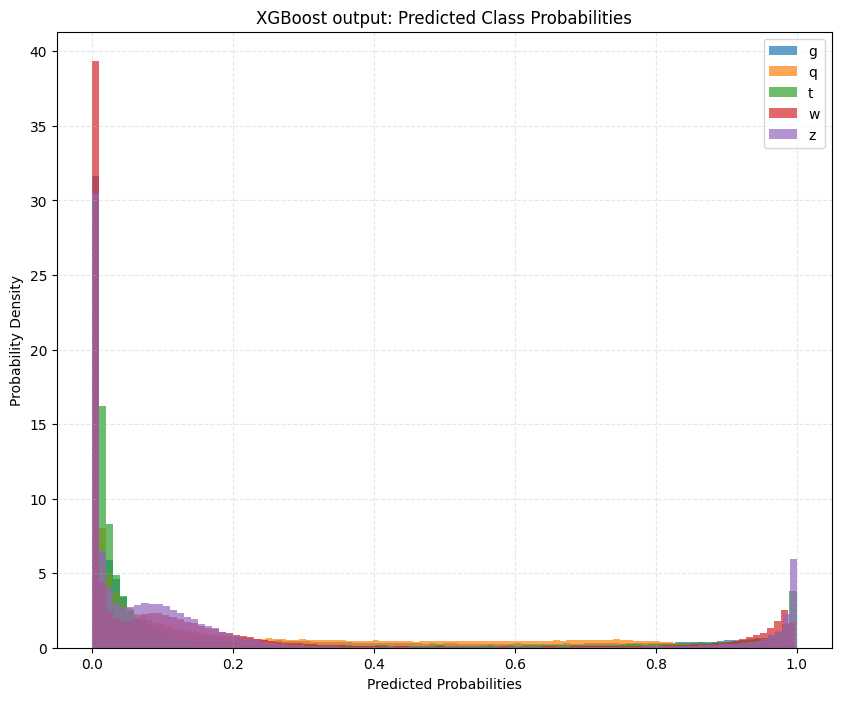

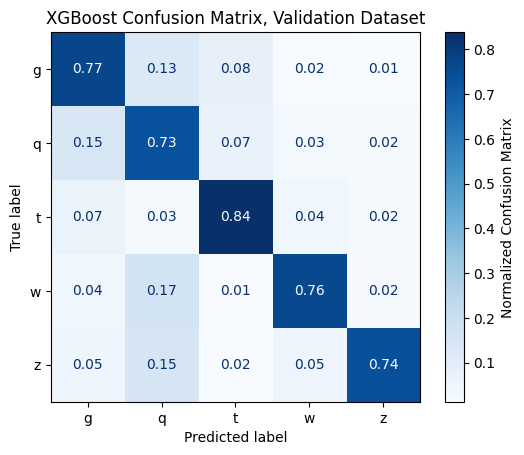

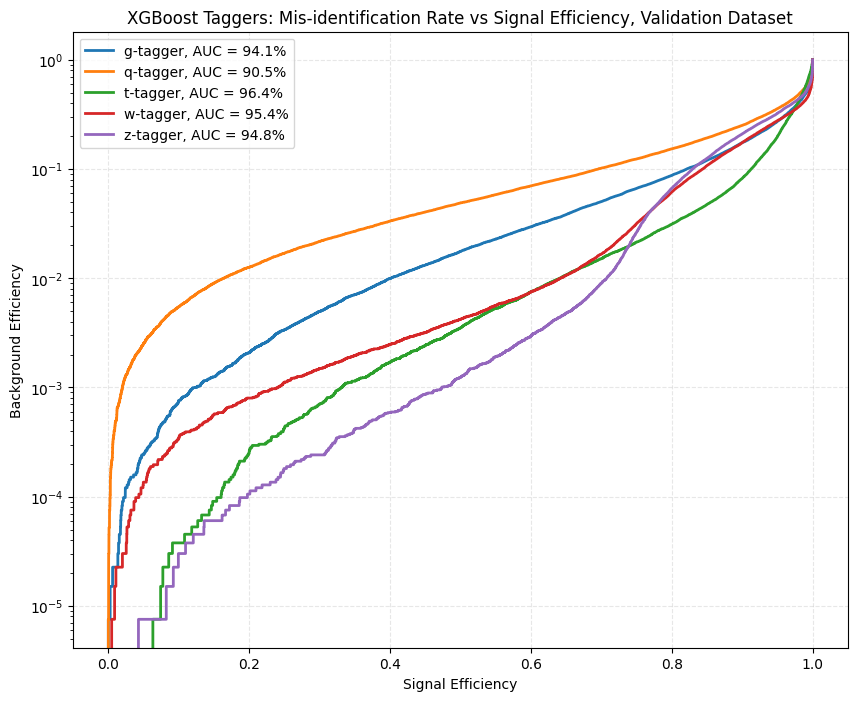

In [ ]:
# predict on validation set
y_pred_prob_val_xgb = opt_xgb.predict_proba(x_val)
y_pred_val_xgb = y_pred_prob_val_xgb.argmax(axis=1)

# check accuracy and performance
accuracy = accuracy_score(y_val, y_pred_val_xgb)
print(f"Validation Accuracy: {accuracy*100:.2f}%.\n")
print(classification_report(y_val, y_pred_val_xgb, target_names=label_encoder.classes_))

# plot XGBoost output
output_proba(y_pred_prob_val_xgb, label_encoder, model_name="XGBoost")

# plot confusion matrix
plot_confusion_matrix(y_val, y_pred_val_xgb, label_encoder, model_name="XGBoost", dataset_name="Validation")

# plot ROC curves
plot_roc(y_val, y_pred_prob_val_xgb, label_encoder, model_name="XGBoost", dataset_name="Validation")

### Evaluate on the Test Dataset

Still alive
Test Dataset Accuracy: 76.79%
              precision    recall  f1-score   support

           g       0.72      0.76      0.74     33425
           q       0.60      0.74      0.66     32213
           t       0.83      0.84      0.84     33570
           w       0.84      0.76      0.80     33417
           z       0.91      0.74      0.82     33375

    accuracy                           0.77    166000
   macro avg       0.78      0.77      0.77    166000
weighted avg       0.78      0.77      0.77    166000



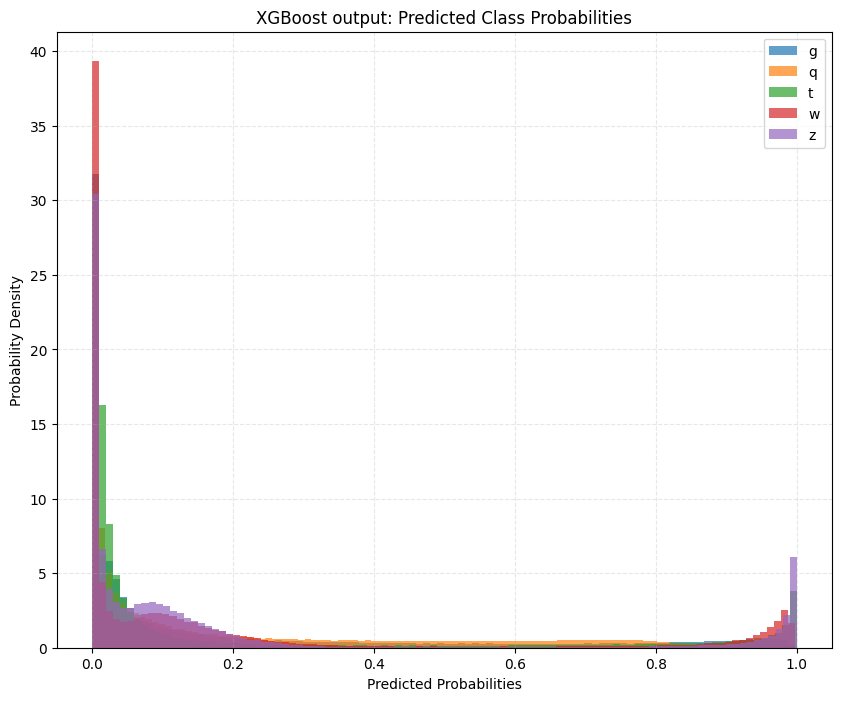

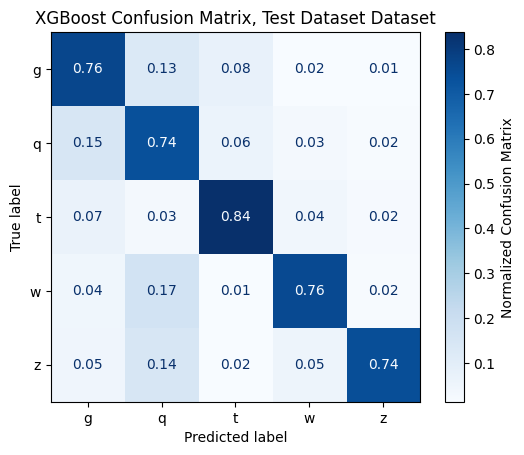

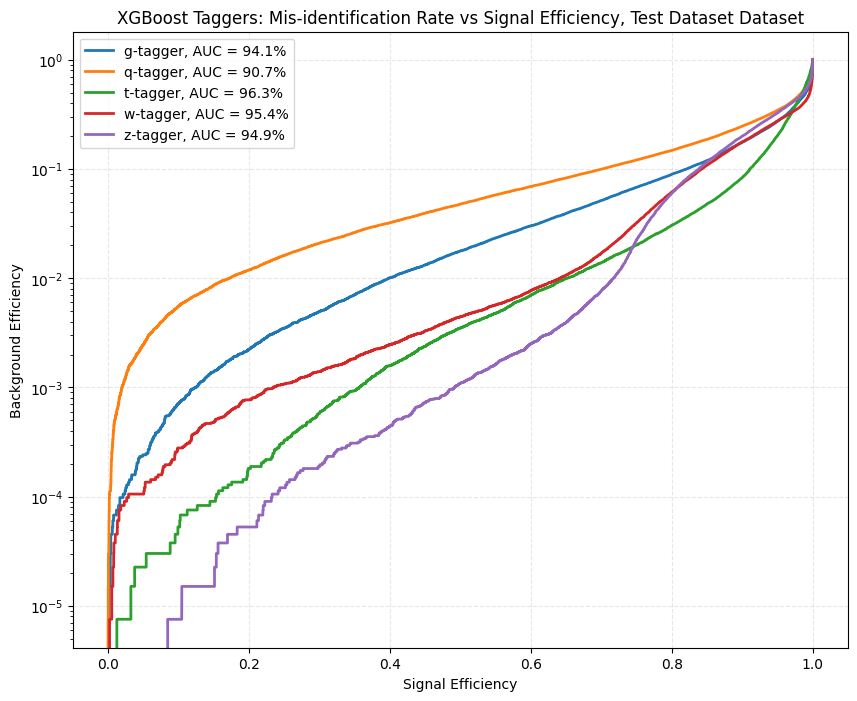

In [ ]:
# make a prediction on the test dataset
y_pred_prob_xtest = opt_xgb.predict_proba(x_test)
y_pred_xtest = y_pred_prob_xtest.argmax(axis=1)

# calculate accuracy
accuracy_xtest = accuracy_score(y_test, y_pred_xtest)
print(f"Test Dataset Accuracy: {accuracy_xtest*100:.2f}%")
print(classification_report(y_test, y_pred_xtest, target_names=label_encoder.classes_))

# plot XGBoost output
output_proba(y_pred_prob_xtest, label_encoder, model_name="XGBoost")

# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_xtest, label_encoder, model_name="XGBoost", dataset_name="Test Dataset")

# plot ROC curves
plot_roc(y_test, y_pred_prob_xtest, label_encoder, model_name="XGBoost", dataset_name="Test Dataset")

# 3.2) **CatBoost**




In [ ]:

def evaluate_model(y_true, y_pred, y_proba, title_suffix="Model Evaluation"):

    # Accuracy and classification report
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion matrix
    class_names = np.unique(np.concatenate((y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f"Confusion Matrix {title_suffix}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC
    y_bin = label_binarize(y_true, classes=class_names)
    n_classes = y_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mis-identification Rate (False Positive Rate)', fontsize=12)
    plt.ylabel('Signal Efficiency (True Positive Rate)', fontsize=12)
    plt.title(f'Multiclass ROC Curve {title_suffix}', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X_cat, y_cat = data['data'], data['target']

In [ ]:
X_temp, X_test_cat, y_temp, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
X_train, X_val_cat, y_train, y_val_cat = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

### Define and Train the Model

In [ ]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    early_stopping_rounds=5,
    task_type='CPU',
    verbose=100
)

In [ ]:
model.fit(X_train, y_train)

0:	learn: 0.7184177	total: 1.6s	remaining: 26m 38s
Still alive
Still alive
100:	learn: 0.7568916	total: 2m 42s	remaining: 24m 10s
Still alive
Still alive
Still alive
200:	learn: 0.7643614	total: 5m 24s	remaining: 21m 29s
Still alive
Still alive
Still alive
300:	learn: 0.7694518	total: 8m 4s	remaining: 18m 44s
Still alive
Still alive
Still alive
400:	learn: 0.7736285	total: 10m 48s	remaining: 16m 8s
Still alive
Still alive
500:	learn: 0.7771225	total: 13m 34s	remaining: 13m 31s
Still alive
Still alive
Still alive
600:	learn: 0.7804116	total: 16m 13s	remaining: 10m 46s
Still alive
Still alive
Still alive
700:	learn: 0.7835984	total: 18m 51s	remaining: 8m 2s
Still alive
Still alive
800:	learn: 0.7867731	total: 21m 35s	remaining: 5m 21s
Still alive
Still alive
Still alive
900:	learn: 0.7894639	total: 24m 18s	remaining: 2m 40s
Still alive
Still alive
Still alive
999:	learn: 0.7921827	total: 26m 57s	remaining: 0us


Evaluation on the validation dataset

In [ ]:
y_pred_cat = model.predict(X_val_cat)
y_proba_cat = model.predict_proba(X_val_cat)

In [ ]:
y_pred_cat = y_pred_cat.ravel()

Accuracy: 0.7652590361445784

Classification Report:
               precision    recall  f1-score   support

           g       0.72      0.76      0.74     33450
           q       0.60      0.73      0.66     32134
           t       0.83      0.84      0.83     33200
           w       0.84      0.76      0.80     33607
           z       0.90      0.74      0.81     33609

    accuracy                           0.77    166000
   macro avg       0.78      0.77      0.77    166000
weighted avg       0.78      0.77      0.77    166000



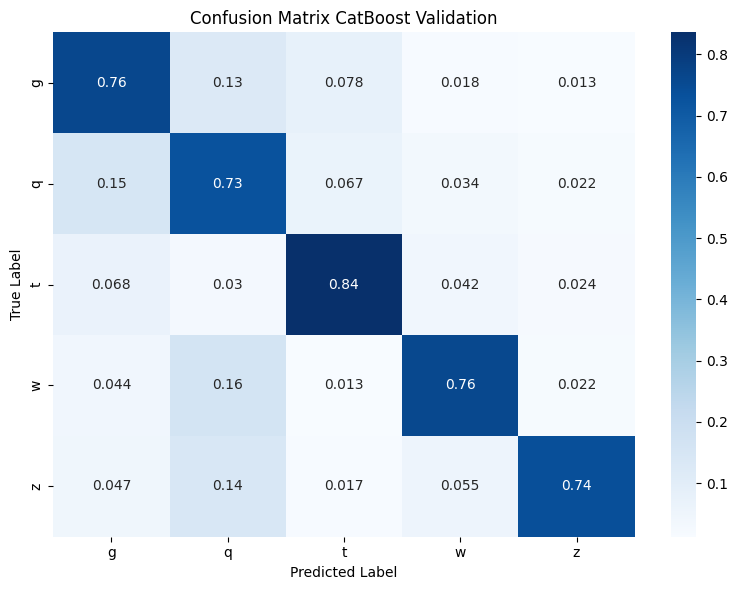

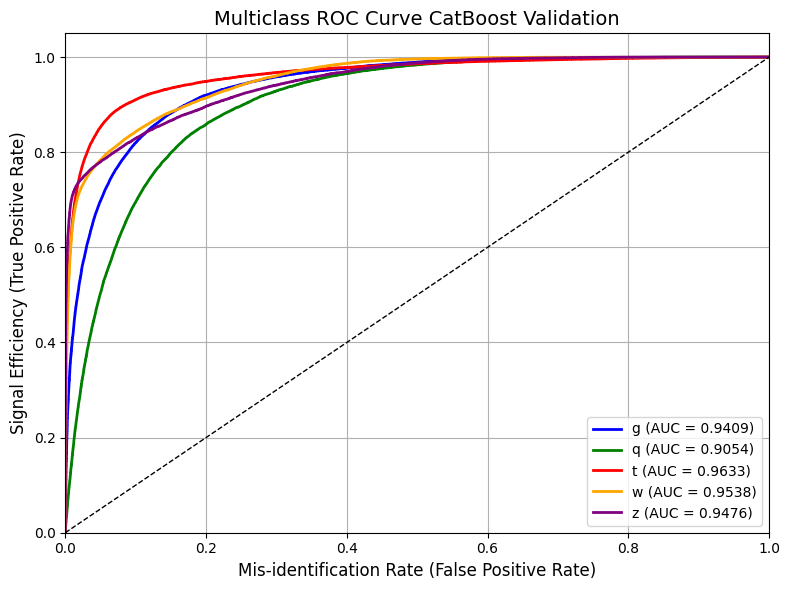

In [ ]:
evaluate_model(y_val_cat, y_pred_cat, y_proba_cat,  title_suffix='CatBoost Validation')

### Evaluate on the Test Dataset

In [ ]:
y_pred_cat = model.predict(X_test_cat)
y_proba_cat = model.predict_proba(X_test_cat)
y_pred_cat = y_pred_cat.ravel()

Accuracy: 0.7653975903614458

Classification Report:
               precision    recall  f1-score   support

           g       0.72      0.76      0.74     33414
           q       0.60      0.73      0.66     32216
           t       0.83      0.84      0.84     33475
           w       0.84      0.76      0.80     33595
           z       0.90      0.74      0.81     33300

    accuracy                           0.77    166000
   macro avg       0.78      0.77      0.77    166000
weighted avg       0.78      0.77      0.77    166000



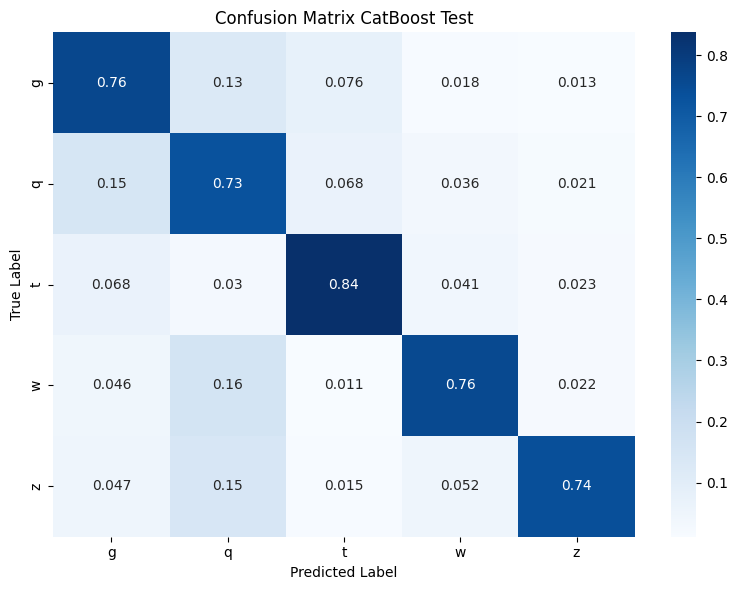

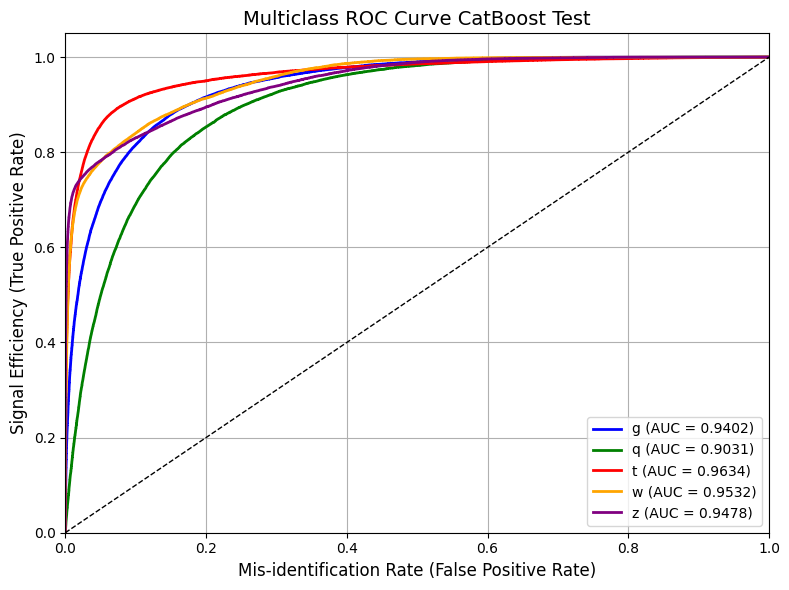

In [ ]:
evaluate_model(y_test_cat, y_pred_cat, y_proba_cat,  title_suffix='CatBoost Test')

# 4) **Check for correlations between the features**  


The followings cells are an attempt at exploring the correlations between the features, and try to see a difference in the overall accuracy and evaluation metrics after removing the highly-correlated ones.  

Because we didn't have much time to fully work with our workflow, we stopped at the evaluation on the dataset.

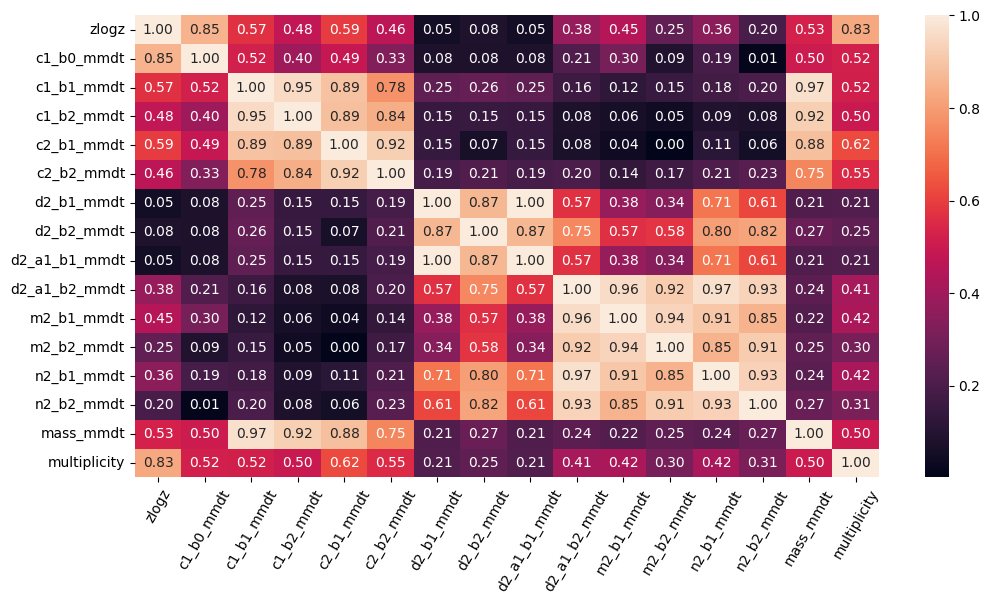

In [ ]:
plt.figure(figsize=(12,6))
correlation_matrix = np.abs(x_train.corr())
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.xticks(rotation=60)
plt.show()

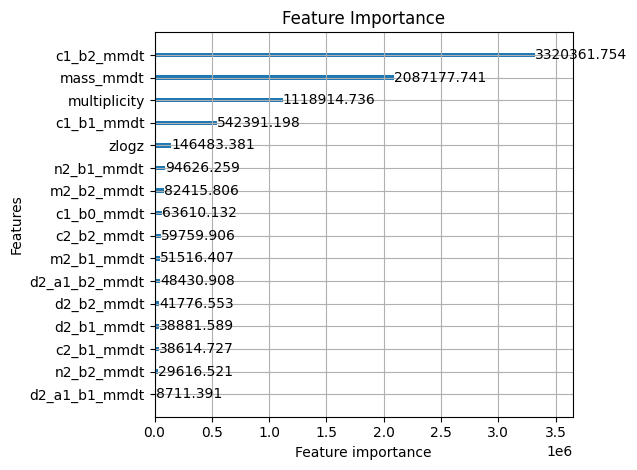

In [ ]:
lgb.plot_importance(gbm_, max_num_features=16, importance_type="gain")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

We will remove highly correlated features from our main model and see how it affects the training phase.

In [ ]:
# from correlation matrix and feature importance plot we remove these features
x_train_new = x_train.drop(columns=["c1_b1_mmdt", "c2_b1_mmdt", "d2_a1_b1_mmdt", "d2_b1_mmdt",
                                    "d2_a1_b2_mmdt", "m2_b1_mmdt", "n2_b1_mmdt", "n2_b2_mmdt"])
x_val_new = x_val.drop(columns=["c1_b1_mmdt", "c2_b1_mmdt", "d2_a1_b1_mmdt", "d2_b1_mmdt",
                                "d2_a1_b2_mmdt", "m2_b1_mmdt", "n2_b1_mmdt", "n2_b2_mmdt"])
train_set_new = lgb.Dataset(x_train_new, label=y_train)
val_set_new = lgb.Dataset(x_val_new, label=y_val, reference=train_set_new)

Training until validation scores don't improve for 5 rounds
[5]	training's multi_logloss: 1.2396	training's multi_error: 0.25797	validation's multi_logloss: 1.24089	validation's multi_error: 0.25953
[10]	training's multi_logloss: 1.04807	training's multi_error: 0.2566	validation's multi_logloss: 1.05034	validation's multi_error: 0.257898
[15]	training's multi_logloss: 0.931972	training's multi_error: 0.254928	validation's multi_logloss: 0.934811	validation's multi_error: 0.256416
[20]	training's multi_logloss: 0.855724	training's multi_error: 0.253311	validation's multi_logloss: 0.859101	validation's multi_error: 0.254765
[25]	training's multi_logloss: 0.805442	training's multi_error: 0.251785	validation's multi_logloss: 0.809275	validation's multi_error: 0.253542
[30]	training's multi_logloss: 0.773677	training's multi_error: 0.251022	validation's multi_logloss: 0.777986	validation's multi_error: 0.25306
[35]	training's multi_logloss: 0.750318	training's multi_error: 0.25002	validatio

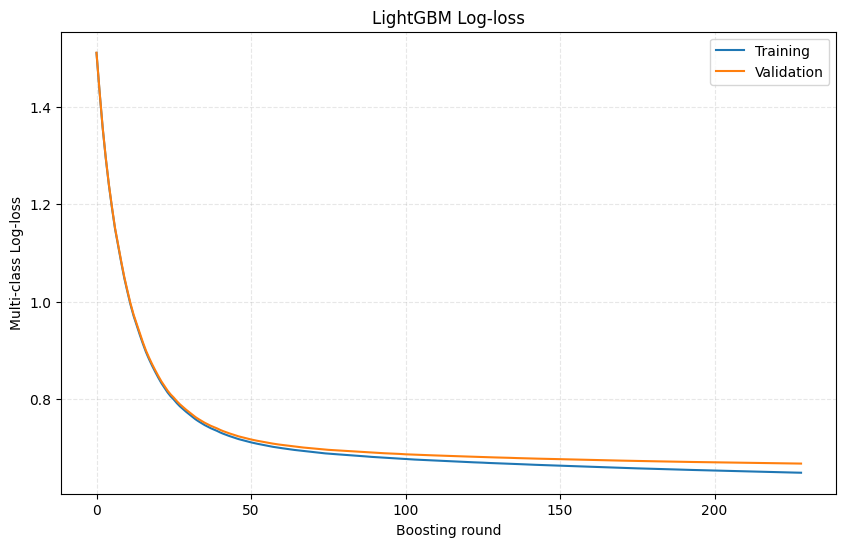

In [ ]:
params= {
    "objective": "multiclass",
    "metric": ["multi_logloss", "multi_error"],
    "boosting_type": "gbdt",
    "num_class": 5,
    "max_depth": 6,
    "num_leaves": 48,   # sometimes suggested to be <= 2^max_depth
    "feature_fraction": 0.8,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "learning_rate": 0.05,
    "lambda_l1": 1.0,
    "lambda_l2": 3.0,
    "min_child_samples": 30,
    "min_split_gain": 0.0,
    "min_data_in_leaf": 20,
    "verbosity": -1,
}

train_results = {}

callbacks = [
    lgb.early_stopping(stopping_rounds=5),     # help avoiding overfitting and saves time
    lgb.record_evaluation(train_results),    # store training history for plotting
    lgb.log_evaluation(period=5)           # print every 5 rounds
]

bst_new = lgb.train(params,
                train_set_new,
                num_boost_round=2000,
                valid_sets=[val_set_new, train_set_new],  # evaluate performance on both the validation and training dataset; uses only val_set for early stopping
                valid_names=["validation", "training"],
                callbacks=callbacks,
                )

# plot the performance of both the training and validation to check for overfitting or underfitting
plt.figure(figsize=(10,6))
plt.plot(train_results["training"]["multi_logloss"], label="Training")
plt.plot(train_results["validation"]["multi_logloss"], label="Validation")
plt.xlabel("Boosting round")
plt.ylabel("Multi-class Log-loss")
plt.title("LightGBM Log-loss")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

Validation Accuracy: 76.10%.

              precision    recall  f1-score   support

           g       0.71      0.76      0.73     33425
           q       0.59      0.73      0.65     32213
           t       0.82      0.84      0.83     33570
           w       0.85      0.75      0.80     33417
           z       0.91      0.73      0.81     33375

    accuracy                           0.76    166000
   macro avg       0.78      0.76      0.76    166000
weighted avg       0.78      0.76      0.77    166000



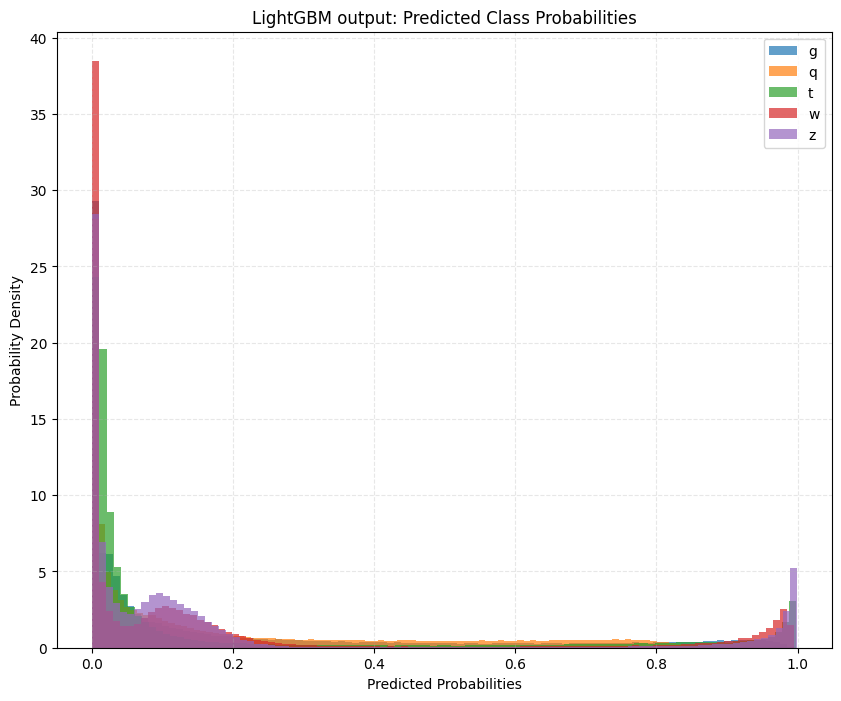

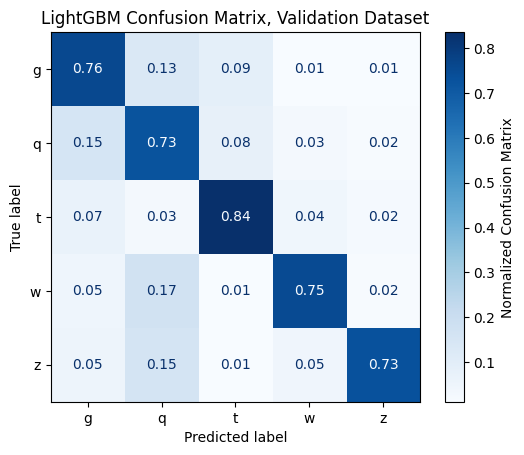

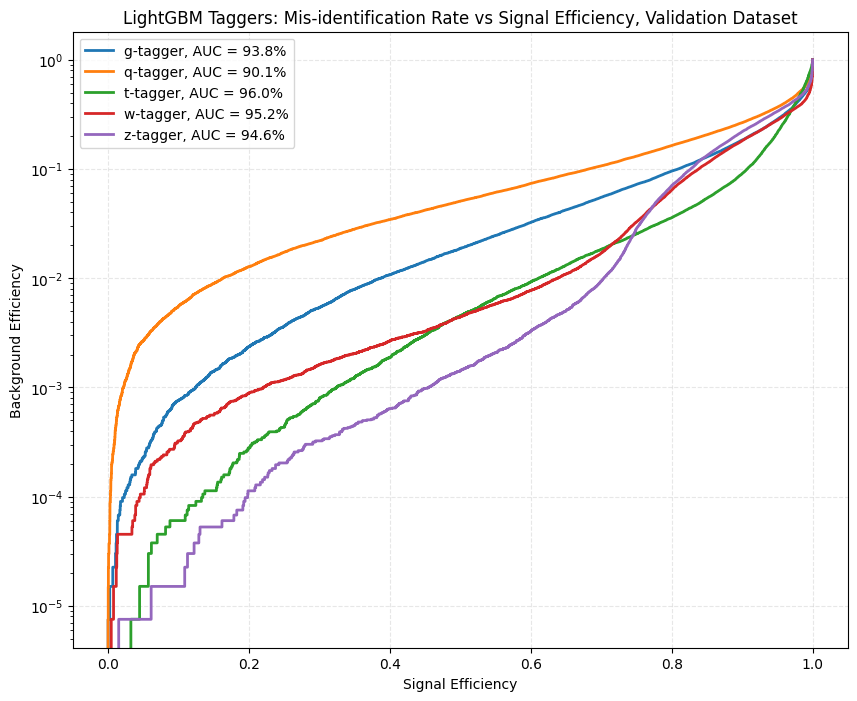

In [ ]:
# predict class probabilities for every jet in the validation dataset using the best iteration picked by early-stopping
y_pred_prob_val_new = bst_new.predict(x_val_new, num_iteration=bst_new.best_iteration)
# convert probabilities to class labels
y_pred_val_new = y_pred_prob_val_new.argmax(axis=1)

# check accuracy and performance
accuracy_new = accuracy_score(y_val, y_pred_val_new)
print(f"Validation Accuracy: {accuracy_new*100:.2f}%.\n")
print(classification_report(y_val, y_pred_val_new, target_names=label_encoder.classes_))

# plot LightGBM output
output_proba(y_pred_prob_val_new, label_encoder, model_name="LightGBM")

# plot confusion matrix
plot_confusion_matrix(y_val, y_pred_val_new, label_encoder, model_name="LightGBM", dataset_name="Validation")

# plot ROC curves
plot_roc(y_val, y_pred_prob_val_new, label_encoder, model_name="LightGBM", dataset_name="Validation")

# 5) **Alternative Method: Multinomial Logistic Regression**

### Define and Train the Model

In [ ]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

Still alive


In [ ]:
X_temp, X_test_mlr, y_temp, y_test_mlr = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_mlr, X_val_mlr, y_train_mlr, y_val_mlr = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
)

# Train on training set
pipeline.fit(X_train_mlr, y_train_mlr)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Still alive


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

Evaluation on validation dataset

In [ ]:
y_pred_mlr = pipeline.predict(X_val_mlr)
y_proba_mlr = pipeline.predict_proba(X_val_mlr)

Accuracy: 0.6890060240963856

Classification Report:
               precision    recall  f1-score   support

           g       0.71      0.70      0.70     33450
           q       0.58      0.62      0.60     32134
           t       0.81      0.77      0.79     33200
           w       0.64      0.69      0.66     33607
           z       0.73      0.66      0.69     33609

    accuracy                           0.69    166000
   macro avg       0.69      0.69      0.69    166000
weighted avg       0.69      0.69      0.69    166000



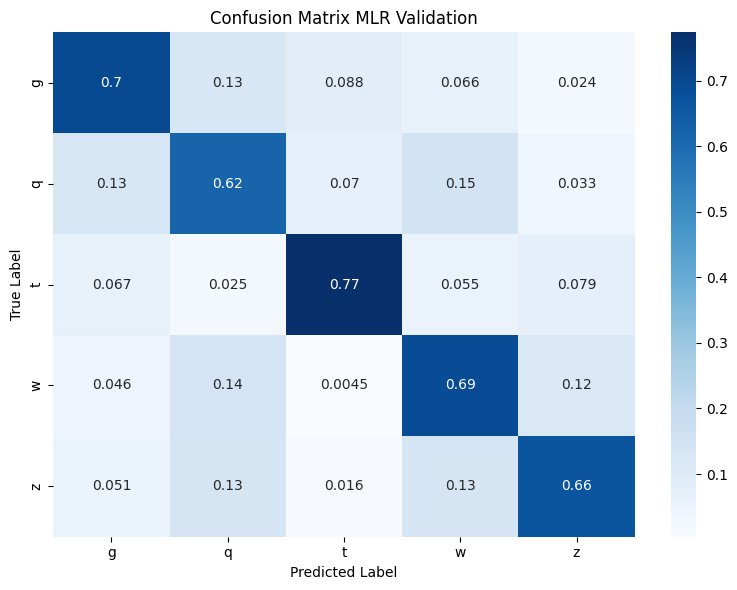

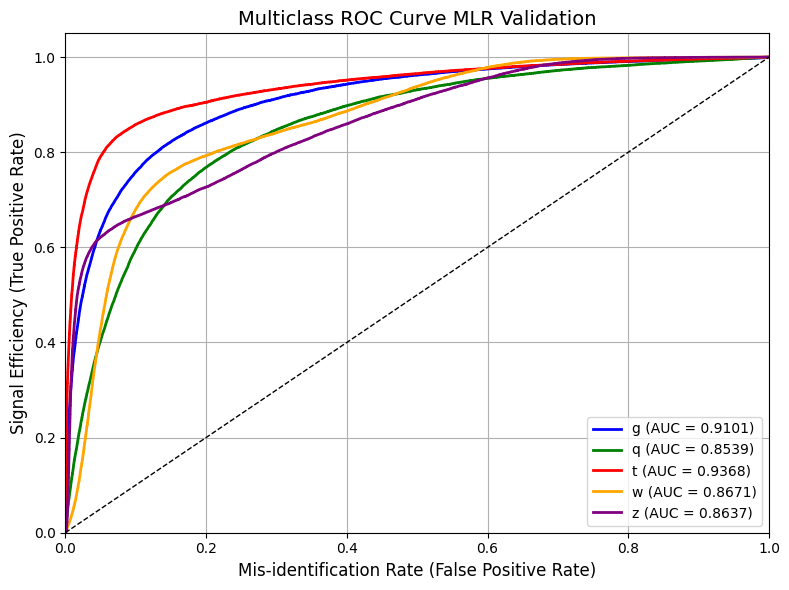

In [ ]:
evaluate_model(y_val_mlr, y_pred_mlr, y_proba_mlr, title_suffix='MLR Validation')

Evaluation on test dataset

In [ ]:
y_pred_mlr = pipeline.predict(X_test_mlr)
y_proba_mlr = pipeline.predict_proba(X_test_mlr)

Accuracy: 0.6883493975903614

Classification Report:
               precision    recall  f1-score   support

           g       0.70      0.69      0.70     33414
           q       0.58      0.62      0.60     32216
           t       0.82      0.77      0.79     33475
           w       0.64      0.69      0.66     33595
           z       0.72      0.66      0.69     33300

    accuracy                           0.69    166000
   macro avg       0.69      0.69      0.69    166000
weighted avg       0.69      0.69      0.69    166000



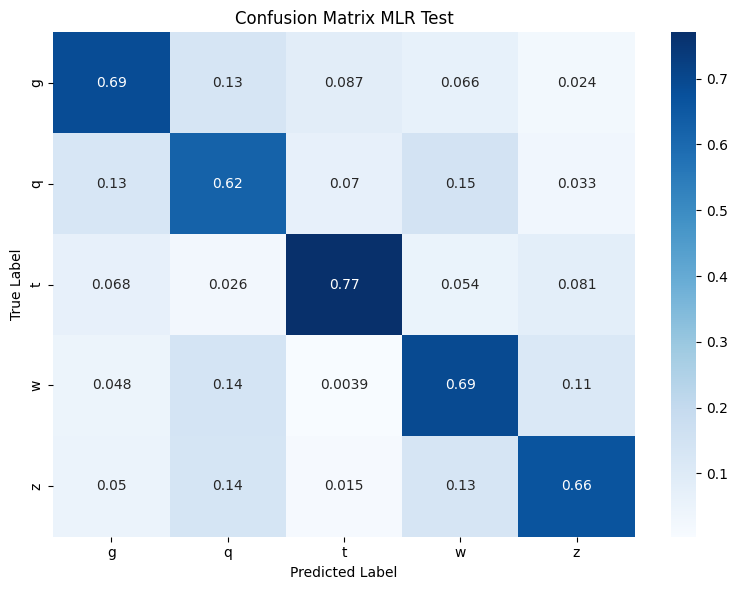

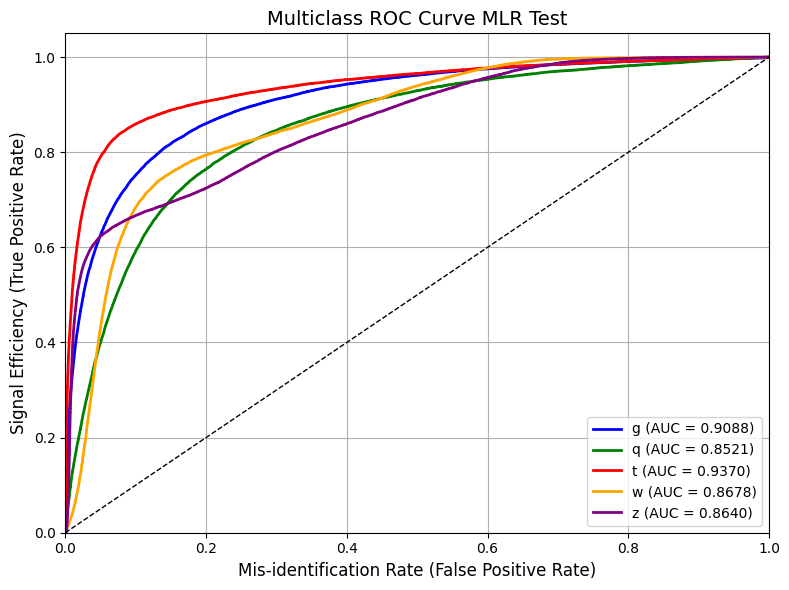

In [ ]:
evaluate_model(y_test_mlr, y_pred_mlr, y_proba_mlr, title_suffix='MLR Test')

# 2.2) LightGBM optimization with FLAML
Because the optimization with FLAML requires the downgrading of the numpy to the 1.26.4 version which needs to restart the kernel, so we decided to put this optimization at the very end of the notebook.  

However, accroding to the logical flow of the work, this part should be seen as the continuation of the section LightGBM optimization with optuna

**Results of the optimization**

Here you can see the results of the evaluation of the LightGBM optimized with FLAML. Since, as mentioned earlier, the execution of the further cells requires downgrading, we are putting the results as attached pictures.

**Accuracy and classification report for the validation dataset**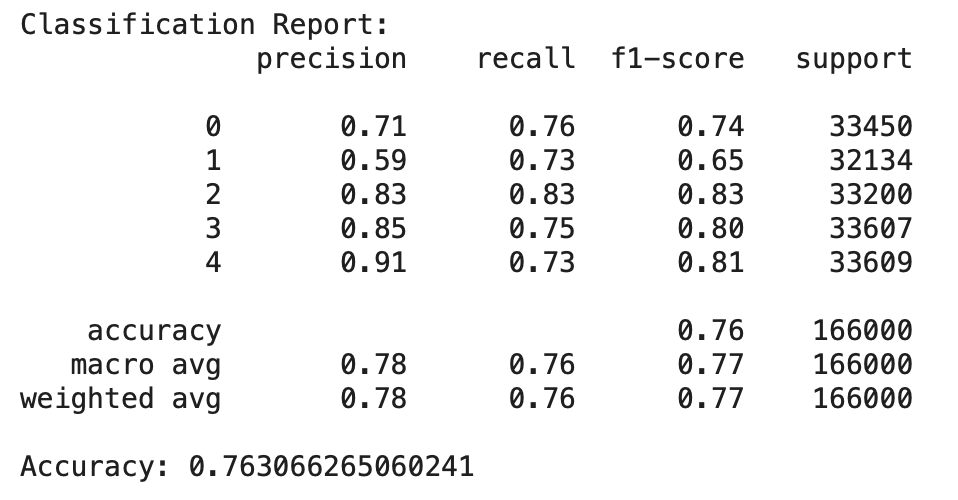

**ROC Curve for Validation**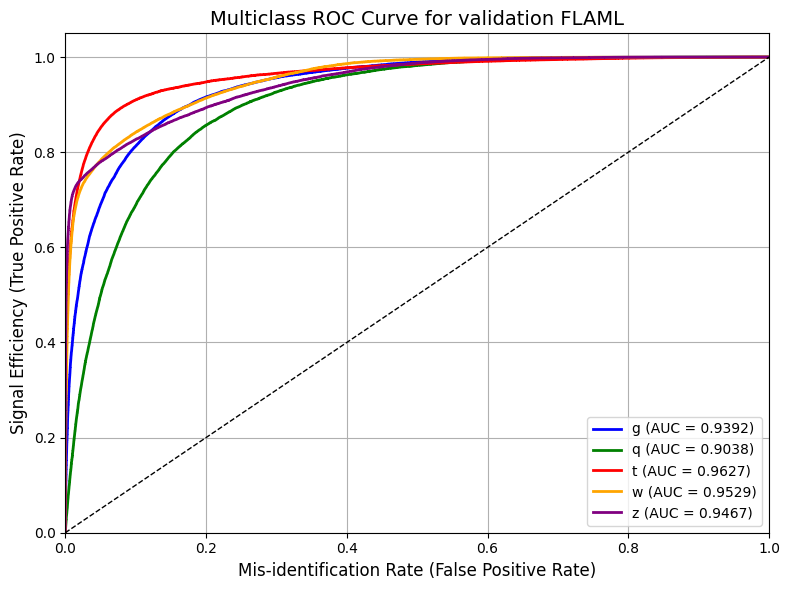

**Confusion matrix for validation**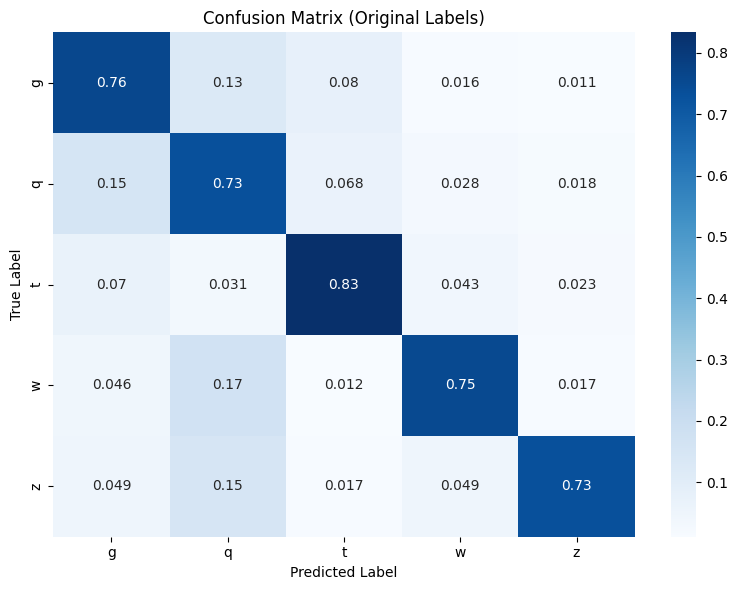

**Accuracy and classification report for test dataset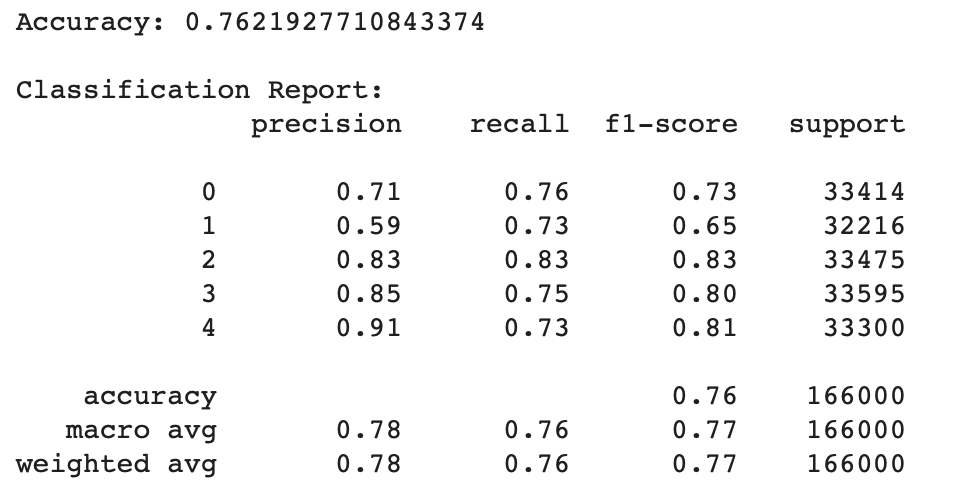**

**ROC curve for test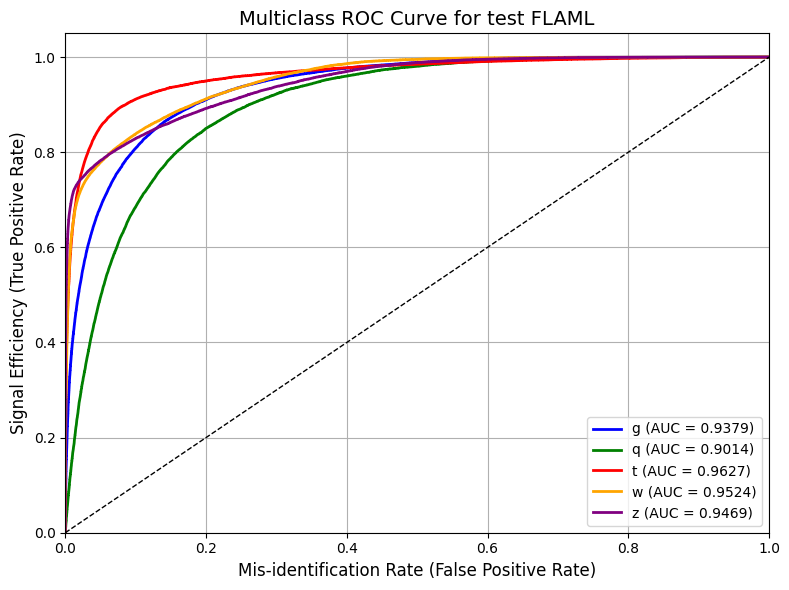**

**Confusion matrix for test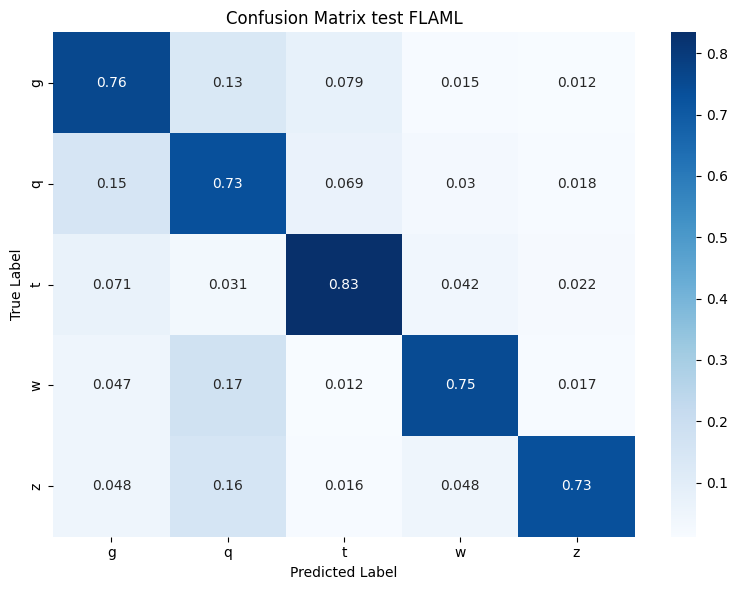**

**Re-running all the cells takes a lot of time and sometimes hours, adding the Colab disconnecting, so DO NOT RUN THESE CELLS.**


In [ ]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

In [ ]:
X_temp, X_test_flm, y_temp, y_test_flm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_flm, X_val_flm, y_train_flm, y_val_flm = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [ ]:
pip install numpy==1.26.4

In [ ]:
pip install flaml

In [ ]:
from flaml import AutoML

Defining the model

In [ ]:
automl = AutoML()
settings = {
    "time_budget": 60,
    "metric": "log_loss",
    "task": "classification",
    "estimator_list": ["lgbm"],
    "log_file_name": "flaml_lgbm.log",
    "verbose": 1
}
automl.fit(X_train=X_train_flm, y_train=y_train_flm, **settings)

In [ ]:
y_pred_flm = automl.predict(X_val_flm)
y_pred_proba_flm = automl.predict_proba(X_val_flm)

Best hyperparameters

In [ ]:
print("\nBest LightGBM hyperparameters found:")
print(automl.best_config)

best_lgbm_model = automl.model.estimator

Evaluation on the validation dataset

In [ ]:
evaluate_model(y_val_flm, y_pred_flm, y_proba_flm,  title_suffix='FLAML Validation')

Evaluation on the test dataset

In [ ]:
y_pred_flm = automl.predict(X_test_flm)
y_pred_proba_flm = automl.predict_proba(X_test_flm)

In [ ]:
evaluate_model(y_test_flm, y_pred_flm, y_proba_flm,  title_suffix='FLAML Test')